# **Изучение данных о психическом здоровье**

# **1. Описание датасета и постановка задачи**

Этот набор данных был собран в рамках комплексного опроса, направленного на изучение факторов, способствующих риску депрессии среди взрослых. Он был собран в ходе анонимного опроса, проведенного в период с января по июнь 2023 года. Опрос охватывал различные города, нацеливаясь на людей из разных слоев общества и профессий. Участники, в возрасте от 18 до 60 лет, добровольно предоставили информацию о таких факторах, как возраст, пол, город, образование, удовлетворенность работой и учебой, количество рабочих и учебных часов, а также семейная история и другие. Участников попросили предоставить данные без необходимости прохождения профессиональной оценки психического здоровья или тестирования на диагнозы.

Целевая переменная, **«Depression»**, отражает, находится ли человек в группе риска по депрессии, что отмечается как **1** («Да») или **0** («Нет»), в зависимости от их ответов на вопросы о факторах образа жизни и демографических данных.

Набор данных был подготовлен таким образом, чтобы дать представление о том, как повседневные факторы могут быть связаны с рисками для психического здоровья, что делает его полезным ресурсом для моделей машинного обучения, направленных на предсказание психического здоровья.

**Цель** — использовать данные опроса о психическом здоровье для изучения факторов, которые могут вызывать депрессию у людей.

# **2. Импорт библиотек и загрузка данных**

In [2]:
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.3.1

In [131]:
# Импорт стандартныъ библиотек
import numpy as np
import pandas as pd

# Импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import phik

# Импорт библиотек для парсинга
import requests
from bs4 import BeautifulSoup

# Импорт библиотек для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import lightgbm as lgb
import xgboost as xgb
from xgb import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import optuna
from sklearn.inspection import permutation_importance

# Игнорируем ошибки
import warnings
warnings.filterwarnings("ignore")

# Установим для отображения всех столбцов в датасете
pd.set_option('display.max_columns', None)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Загружаем данные
df = pd.read_csv("/content/drive/MyDrive/DS/Mental/Mental_train.csv")

print("Первые пять строк датасета:")
df.head()

Первые пять строк датасета:


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [7]:
print(f"В исходном датасете {df.shape[1]} столбцов и {df.shape[0]} строк.")

В исходном датасете 20 столбцов и 140700 строк.


In [8]:
# Посмотрим основную информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

Посмотрим на целевую переменную **Depression**

In [9]:
print(f"Целевая переменная Depression представлена {len(df['Depression'].unique())} значениями, а именно: {df['Depression'].unique()}.")

Целевая переменная Depression представлена 2 значениями, а именно: [0 1].


В нашем случае это задача **бинарной классификации**.

# **3. Очистка и подготовка данных**

## **3.1. Обработка дубликатов**

In [10]:
# Проверим данные на наличие дубликатов
if df.duplicated().sum() == 0:
  print("Дубликаты отсутствуют")
else:
  print(f"В датасете {df.duplicated().sum()} строк с дубликатами.")

Дубликаты отсутствуют


## **3.2. Обработка пропущенных значений**

In [11]:
# Проверим колчиство пропущенных значений:
print("Количество пропущенных значений в каждой колонке:")
df.isnull().sum()

Количество пропущенных значений в каждой колонке:


,0
id,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,0
Profession,36630
Academic Pressure,112803
Work Pressure,27918
CGPA,112802


Мы видим, что в столбцах **Profession, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction** имеется множество пропущенных значений.



Выведем эти столбцы для последующего анализа

In [12]:
df[['Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction']]

,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction
0,Chef,NaN,5.0,NaN,NaN,2.0
1,Teacher,NaN,4.0,NaN,NaN,3.0
2,NaN,5.0,NaN,8.97,2.0,NaN
3,Teacher,NaN,5.0,NaN,NaN,1.0
4,Business Analyst,NaN,1.0,NaN,NaN,1.0
...,...,...,...,...,...,...
140695,NaN,NaN,5.0,NaN,NaN,4.0
140696,Content Writer,NaN,5.0,NaN,NaN,4.0
140697,Marketing Manager,NaN,3.0,NaN,NaN,1.0
140698,Plumber,NaN,5.0,NaN,NaN,2.0


На представленной выборке видно, что пропущенные значения в столбцах зависят от занятости человека (студент или работник)

In [13]:
print("Проверим количество пропущенных значений в столбцах для студентов:")
df.loc[df['Working Professional or Student'] == 'Student'][['Working Professional or Student','Profession',
'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction']].isnull().sum()

Проверим количество пропущенных значений в столбцах для студентов:


,0
Working Professional or Student,0
Profession,27867
Academic Pressure,9
Work Pressure,27898
CGPA,9
Study Satisfaction,10
Job Satisfaction,27893


In [14]:
print("Проверим количество пропущенных значений в столбцах для работников:")
df.loc[df['Working Professional or Student'] == 'Working Professional'][['Working Professional or Student','Profession',
'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction']].isnull().sum()

Проверим количество пропущенных значений в столбцах для работников:


,0
Working Professional or Student,0
Profession,8763
Academic Pressure,112794
Work Pressure,20
CGPA,112793
Study Satisfaction,112793
Job Satisfaction,17


Гипотеза подтвердилась, основная часть пропущенных значений в столбцах, не относящихся к деятельности человека. Для уменьшения размерности можно будет объединить эти столбцы.

Однако у нас все равно имеются пропущенные значения в части строк.

In [15]:
print("Проверим количество пропущенных значений в столбцах для студентов:")
df.loc[(df['Working Professional or Student'] == 'Student') &
 (df['Academic Pressure'].isnull() | df['CGPA'].isnull() |
  df['Study Satisfaction'].isnull())]

Проверим количество пропущенных значений в столбцах для студентов:


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
17549,17549,Tanya,Female,20.0,Patna,Student,NaN,NaN,NaN,5.55,NaN,NaN,5-6 hours,Moderate,Class 12,No,0.0,3.0,Yes,0
18344,18344,Shivam,Male,30.0,Faridabad,Student,NaN,5.0,NaN,5.74,NaN,NaN,Less than 5 hours,Unhealthy,MCA,Yes,0.0,3.0,Yes,1
21880,21880,Aarush,Male,38.0,Chennai,Student,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Healthy,Class 12,No,2.0,3.0,No,0
52737,52737,Aarav,Male,28.0,Vadodara,Student,NaN,3.0,NaN,NaN,4.0,NaN,Less than 5 hours,Healthy,BBA,No,12.0,2.0,No,0
58062,58062,Ishita,Female,32.0,Vadodara,Student,NaN,5.0,NaN,NaN,NaN,NaN,Less than 5 hours,Unhealthy,Class 12,Yes,11.0,5.0,No,1
70453,70453,Veda,Female,20.0,Ahmedabad,Student,NaN,NaN,NaN,NaN,NaN,2.0,Less than 5 hours,Moderate,Class 12,Yes,12.0,3.0,Yes,1
75007,75007,Aarav,Male,21.0,Lucknow,Student,NaN,NaN,2.0,NaN,NaN,1.0,7-8 hours,Moderate,Class 12,Yes,3.0,3.0,Yes,0
102714,102714,Aahana,Female,18.0,Bhopal,Student,NaN,4.0,NaN,5.88,NaN,NaN,Less than 5 hours,Moderate,Class 12,Yes,5.0,1.0,No,1
105773,105773,Anand,Male,18.0,Ahmedabad,Student,NaN,NaN,NaN,NaN,NaN,1.0,Less than 5 hours,Moderate,Class 12,Yes,9.0,5.0,No,1
110097,110097,Abhinav,Male,34.0,Pune,Student,NaN,1.0,NaN,NaN,5.0,NaN,Less than 5 hours,Unhealthy,M.Ed,Yes,10.0,3.0,Yes,0


Строки с индексами 21880, 75007, 129756 были ошибочно отнесены к категории студентов.
Поменяем им категорию.

In [16]:
df.loc[
    (df['Working Professional or Student'] == 'Student') &
    (df['Work Pressure'].notna()),
    'Working Professional or Student'
] = 'Working Professional'

Остальные строки можно удалить

In [17]:
df = df.loc[~(
    (df['Working Professional or Student'] == 'Student') &
    (df['Academic Pressure'].isnull() |
     df['CGPA'].isnull() |
     df['Study Satisfaction'].isnull())
)]

Теперь проделаем ту же самую работу с работниками

In [18]:
print("Проверим количество пропущенных значений в столбцах для работников:")
df.loc[(df['Working Professional or Student'] == 'Working Professional') &
 (df['Work Pressure'].isnull() | df['Job Satisfaction'].isnull())]

Проверим количество пропущенных значений в столбцах для работников:


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
15846,15846,Shrey,Male,53.0,Vasai-Virar,Working Professional,NaN,NaN,NaN,NaN,NaN,5.0,More than 8 hours,Unhealthy,Class 12,No,12.0,1.0,No,0
18752,18752,Aarti,Female,18.0,Kalyan,Working Professional,NaN,2.0,NaN,8.14,5.0,NaN,Less than 5 hours,Healthy,Class 12,Yes,7.0,1.0,Yes,1
25647,25647,Ishwar,Male,57.0,Kalyan,Working Professional,NaN,NaN,1.0,NaN,NaN,NaN,Less than 5 hours,Unhealthy,Class 12,No,4.0,1.0,No,0
34694,34694,Kriti,Female,46.0,Meerut,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,5-6 hours,Moderate,Class 12,Yes,12.0,3.0,No,0
35612,35612,Siddhesh,Male,27.0,Vadodara,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,Less than 5 hours,Unhealthy,B.Pharm,No,11.0,3.0,No,1
41915,41915,Advait,Male,18.0,Kolkata,Working Professional,NaN,4.0,NaN,8.04,3.0,NaN,5-6 hours,Healthy,Class 12,Yes,1.0,5.0,Yes,1
52199,52199,Manan,Male,50.0,Agra,Working Professional,NaN,NaN,4.0,NaN,NaN,NaN,5-6 hours,Unhealthy,Class 12,No,1.0,3.0,Yes,0
55222,55222,Trisha,Female,21.0,Varanasi,Working Professional,NaN,NaN,5.0,NaN,NaN,NaN,7-8 hours,Moderate,B.Arch,No,11.0,2.0,Yes,0
55827,55827,Prachi,Female,19.0,Kalyan,Working Professional,NaN,3.0,NaN,8.11,2.0,NaN,5-6 hours,Unhealthy,Class 12,Yes,4.0,4.0,No,1
57196,57196,Manvi,Female,20.0,Visakhapatnam,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,Less than 5 hours,Moderate,Class 12,No,0.0,4.0,Yes,1


Строки с индексами 18752, 41915, 55827, 99062, 101189 были ошибочно отнесены к категории работников.
Поменяем им категорию

In [19]:
df.loc[
    (df['Working Professional or Student'] == 'Working Professional') &
    (df['Academic Pressure'].notna()),
    'Working Professional or Student'
] = 'Student'

Остальные строки также можно удалить

In [20]:
df = df.loc[~(
    (df['Working Professional or Student'] == 'Working Professional') &
    (df['Work Pressure'].isnull() |
     df['Job Satisfaction'].isnull())
)]

Проверим есть ли строки, в которых одновременно указано значения в учебных и рабочих данных

In [21]:
df.loc[(df['Work Pressure'].notnull()) & (df['Academic Pressure'].notnull())]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression


In [22]:
df.loc[(df['Job Satisfaction'].notnull()) & (df['Study Satisfaction'].notnull())]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
1428,1428,Rishi,Male,29.0,Srinagar,Student,NaN,3.0,NaN,9.63,3.0,3.0,7-8 hours,Moderate,M.Pharm,No,8.0,5.0,No,0
116703,116703,Neil,Male,25.0,Bangalore,Student,NaN,4.0,NaN,9.44,5.0,2.0,Less than 5 hours,Unhealthy,PhD,Yes,4.0,1.0,No,1


Такие строки есть, укажем нулевые значения в столбце **Job Satisfaction**, так как это студенты

In [23]:
df.loc[(df['Job Satisfaction'].notnull()) & (df['Study Satisfaction'].notnull()), 'Job Satisfaction'] = 0

Объединим столбцы **Work Presure** и **Academy Pressure** в **Pressure**

In [24]:
df['Academic Pressure'].fillna(0, inplace=True)
df['Work Pressure'].fillna(0, inplace=True)
df['Pressure'] = df['Academic Pressure']+ df['Work Pressure']
df = df.drop(['Academic Pressure', 'Work Pressure'], axis=1)

Объединим столбцы **Job Satisfaction** и **Study Satisfaction** в **Satisfaction**

In [25]:
df['Study Satisfaction'].fillna(0, inplace=True)
df['Job Satisfaction'].fillna(0, inplace=True)
df['Satisfaction'] = df['Study Satisfaction']+ df['Job Satisfaction']
df = df.drop(['Study Satisfaction', 'Job Satisfaction'], axis=1)

Также заполним пропущенные значения в столбце **CGPA**

In [26]:
df['CGPA'].fillna(0, inplace=True)



---


Также в столбцах **Dietary Habits, Degree, Financial Stress** имеются единичные случаи пропущенных значений.

In [27]:
df.loc[(df['Dietary Habits'].isnull())|(df['Degree'].isnull())|(df['Financial Stress'].isnull())]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
22377,22377,Manvi,Female,32.0,Varanasi,Student,NaN,5.64,5-6 hours,Healthy,BCA,No,12.0,NaN,No,1,3.0,1.0
51485,51485,Ishwar,Male,37.0,Hyderabad,Working Professional,NaN,0.00,More than 8 hours,Moderate,Class 12,Yes,9.0,NaN,No,0,4.0,2.0
59350,59350,Tanmay,Male,34.0,Agra,Student,NaN,9.04,More than 8 hours,NaN,B.Tech,Yes,4.0,5.0,Yes,1,5.0,1.0
64565,64565,Anvi,Female,23.0,Bangalore,Student,NaN,6.91,5-6 hours,NaN,M.Pharm,No,6.0,3.0,No,1,2.0,5.0
68910,68910,Arav,Male,29.0,Hyderabad,Student,NaN,8.94,Less than 5 hours,Unhealthy,B.Ed,No,12.0,NaN,Yes,0,2.0,3.0
69581,69581,Vikram,Male,48.0,Hyderabad,Working Professional,Consultant,0.00,Less than 5 hours,NaN,MBA,No,5.0,4.0,No,0,3.0,2.0
76436,76436,Raghavendra,Male,37.0,Nashik,Working Professional,Civil Engineer,0.00,7-8 hours,NaN,ME,No,11.0,1.0,No,0,3.0,3.0
97610,97610,Pari,Female,20.0,Kolkata,Student,NaN,6.83,5-6 hours,Healthy,MBBS,No,9.0,NaN,Yes,0,1.0,1.0
110064,110064,Riya,Female,28.0,Srinagar,Working Professional,NaN,0.00,5-6 hours,Unhealthy,NaN,Yes,4.0,2.0,Yes,1,3.0,3.0
128934,128934,Anaya,Female,28.0,Srinagar,Working Professional,NaN,0.00,Less than 5 hours,Unhealthy,NaN,Yes,3.0,3.0,Yes,0,5.0,4.0


Проверим пропущенные значения в столбце **Dietary Habits**

In [28]:
df.loc[df['Dietary Habits'].isnull()]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
59350,59350,Tanmay,Male,34.0,Agra,Student,NaN,9.04,More than 8 hours,NaN,B.Tech,Yes,4.0,5.0,Yes,1,5.0,1.0
64565,64565,Anvi,Female,23.0,Bangalore,Student,NaN,6.91,5-6 hours,NaN,M.Pharm,No,6.0,3.0,No,1,2.0,5.0
69581,69581,Vikram,Male,48.0,Hyderabad,Working Professional,Consultant,0.00,Less than 5 hours,NaN,MBA,No,5.0,4.0,No,0,3.0,2.0
76436,76436,Raghavendra,Male,37.0,Nashik,Working Professional,Civil Engineer,0.00,7-8 hours,NaN,ME,No,11.0,1.0,No,0,3.0,3.0


In [29]:
# Посмотрим какими значениями можно заполнить пропущенные значения
df['Dietary Habits'].value_counts()

,count
Dietary Habits,
Moderate,49689
Unhealthy,46218
Healthy,44735
Yes,2
No,2
More Healthy,2
No Healthy,1
Class 12,1
Indoor,1


In [30]:
# Так как данные нам неизвестны заполним их самым популярным значением (модой)

df.loc[df['Dietary Habits'].isnull(), 'Dietary Habits'] = df['Dietary Habits'].mode().iloc[0]



---


Теперь проверим пропущенные значения в столбце **Degree**



In [31]:
df.loc[df['Degree'].isnull()]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
110064,110064,Riya,Female,28.0,Srinagar,Working Professional,NaN,0.0,5-6 hours,Unhealthy,NaN,Yes,4.0,2.0,Yes,1,3.0,3.0
128934,128934,Anaya,Female,28.0,Srinagar,Working Professional,NaN,0.0,Less than 5 hours,Unhealthy,NaN,Yes,3.0,3.0,Yes,0,5.0,4.0


Всего 2 пропущенных значения. Можно их удалить

In [32]:
df = df.loc[~df['Degree'].isnull()]

---
Теперь проверим пропущенные значения в столбце **Financial Stress**

In [33]:
df.loc[df['Financial Stress'].isnull()]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
22377,22377,Manvi,Female,32.0,Varanasi,Student,NaN,5.64,5-6 hours,Healthy,BCA,No,12.0,NaN,No,1,3.0,1.0
51485,51485,Ishwar,Male,37.0,Hyderabad,Working Professional,NaN,0.00,More than 8 hours,Moderate,Class 12,Yes,9.0,NaN,No,0,4.0,2.0
68910,68910,Arav,Male,29.0,Hyderabad,Student,NaN,8.94,Less than 5 hours,Unhealthy,B.Ed,No,12.0,NaN,Yes,0,2.0,3.0
97610,97610,Pari,Female,20.0,Kolkata,Student,NaN,6.83,5-6 hours,Healthy,MBBS,No,9.0,NaN,Yes,0,1.0,1.0


4 пропущенных значения, которые можно удалить

In [34]:
df = df.loc[~df['Financial Stress'].isnull()]

In [35]:
# Проверим применение методов
df.loc[(df['Dietary Habits'].isnull())|(df['Degree'].isnull())|(df['Financial Stress'].isnull())]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction


Пропущенные значения в столбцах **Dietary Habits, Degree, Financial Stress** теперь отсутсвуют.

## **3.3. Обработка аномалий и выбросов**

### **Категориальные значения**

In [36]:
# Определим столбцы с категориальными значениями
categorical_columns = df.select_dtypes(include=['object']).columns

In [37]:
# Определим количество уникальных значений в категориальных столбцах
for column in categorical_columns:
    num_unique = df[column].nunique()
    print(f"'{column}' имеет {num_unique} уникальных категорий.")

'Name' имеет 422 уникальных категорий.
'Gender' имеет 2 уникальных категорий.
'City' имеет 98 уникальных категорий.
'Working Professional or Student' имеет 2 уникальных категорий.
'Profession' имеет 64 уникальных категорий.
'Sleep Duration' имеет 36 уникальных категорий.
'Dietary Habits' имеет 23 уникальных категорий.
'Degree' имеет 115 уникальных категорий.
'Have you ever had suicidal thoughts ?' имеет 2 уникальных категорий.
'Family History of Mental Illness' имеет 2 уникальных категорий.


In [38]:
# Проверим уникальные значения в категориальных столбцах
for column in categorical_columns:
    print(f"\nТоп-10 уникальных значения в '{column}':\n{df[column].value_counts().head(10)}")


Топ-10 уникальных значения в 'Name':
Name
Rohan          3178
Aarav          2335
Rupak          2176
Aaradhya       2044
Anvi           2035
Raghavendra    1877
Vani           1657
Tushar         1595
Ritvik         1589
Shiv           1568
Name: count, dtype: int64

Топ-10 уникальных значения в 'Gender':
Gender
Male      77448
Female    63215
Name: count, dtype: int64

Топ-10 уникальных значения в 'City':
City
Kalyan           6590
Patna            5922
Vasai-Virar      5764
Kolkata          5688
Ahmedabad        5611
Meerut           5526
Ludhiana         5226
Rajkot           5207
Pune             5207
Visakhapatnam    5175
Name: count, dtype: int64

Топ-10 уникальных значения в 'Working Professional or Student':
Working Professional or Student
Working Professional    112774
Student                  27889
Name: count, dtype: int64

Топ-10 уникальных значения в 'Profession':
Profession
Teacher             24906
Content Writer       7814
Architect            4370
Consultant         

Столбец **Name** имеет 422 уникальных значений. Столбец можно удалить, так как он не полезен для обучения

Столбец **City** имеет 98 уникальных значений. Как показывают [различные исследования](https://www.kcl.ac.uk/cities-increase-your-risk-of-depression-anxiety-and-psychosis-but-bring-mental-health-benefits-too?utm_source=chatgpt.com) большие города сильно влияют на уровень ментального здоровья, поэтому важно оставить и проработать данный параметр.

Столбец **Profession** имеет 64 категории. Можно объединить в категории.

Столбец **Sleep Duration** можно сократить до четырех основных категорий.

**Dietary Habits** также можно сократить до 3 основых категорий.

**Degree** имеет 115 уникальных категорий. Можно попробовать объединить в кластеры










---
Столбец **Sleep Duration**




In [39]:
# Посмотрим на количество уникальных значений
df['Sleep Duration'].value_counts()

,count
Sleep Duration,
Less than 5 hours,38770
7-8 hours,36964
More than 8 hours,32719
5-6 hours,32131
3-4 hours,12
6-7 hours,8
4-5 hours,7
2-3 hours,5
4-6 hours,5


Можно выделить 4 основных категории:
* Less than 5 hours
* 5-7 hours
* 7-8 hours
* More than 8 hours


Остальные значения приведем к этим категория

In [40]:
df.loc[df['Sleep Duration'].isin(['1-2 hours', '40-45 hours', '1-3 hours', '35-36 hours',
                                              'than 5 hours', '3-6 hours', '45', '1-6 hours', '4-6 hours',
                                              '2-3 hours', '4-5 hours', '3-4 hours']), 'Sleep Duration'] = 'Less than 5 hours'
df.loc[df['Sleep Duration'].isin(['55-66 hours','6-7 hours','5-6 hours']), 'Sleep Duration'] = '5-7 hours'
df.loc[df['Sleep Duration'].isin(['9-5 hours', '8 hours', '10-6 hours', '49 hours',
                                              '9-6 hours', '45-48 hours', '9-5', '6-8 hours']), 'Sleep Duration'] = '7-8 hours'
df.loc[df['Sleep Duration'].isin(['10-11 hours', '8-9 hours', '9-11 hours']), 'Sleep Duration'] = 'More than 8 hours'

In [41]:
# Посмотрим на количество уникальных значений после обработки
df['Sleep Duration'].value_counts()

,count
Sleep Duration,
Less than 5 hours,38811
7-8 hours,36975
More than 8 hours,32725
5-7 hours,32140
No,4
Sleep_Duration,2
Unhealthy,2
Moderate,1
Indore,1


В столбце остались аномальные значения. Выведем строки, в которых указаны аномальные значения. Возможно, что были перепутаны столбцы при внесении данных.

In [42]:
df.loc[df['Sleep Duration'].isin(['No', 'Sleep_Duration', 'Unhealthy',
                                              'Moderate', 'Indore', 'Work_Study_Hours',
                                              'Pune'])]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
4021,4021,Keshav,Male,59.0,Ghaziabad,Working Professional,Judge,0.00,Sleep_Duration,Healthy,LLB,Yes,10.0,1.0,No,0,4.0,4.0
27865,27865,Vidhi,Female,31.0,Delhi,Student,NaN,7.27,Moderate,Healthy,B.Arch,No,3.0,1.0,No,0,2.0,5.0
35953,35953,Aarav,Male,34.0,Thane,Working Professional,Consultant,0.00,Sleep_Duration,Moderate,MCA,Yes,9.0,3.0,Yes,0,3.0,3.0
45218,45218,Anjali,Female,44.0,Meerut,Working Professional,Teacher,0.00,Indore,Moderate,MD,No,6.0,4.0,Yes,0,2.0,2.0
66929,66929,Damini,Female,54.0,Bhopal,Working Professional,Doctor,0.00,No,Healthy,MBBS,No,5.0,1.0,No,0,3.0,1.0
68239,68239,Zegmay,Male,46.0,Bhopal,Working Professional,Civil Engineer,0.00,No,Unhealthy,MCA,No,3.0,1.0,Yes,0,5.0,3.0
79764,79764,Kiran,Female,35.0,Jaipur,Working Professional,Mechanical Engineer,0.00,Unhealthy,Unhealthy,BSc,Yes,6.0,2.0,No,0,2.0,1.0
80918,80918,Aaradhya,Female,50.0,Vasai-Virar,Working Professional,Financial Analyst,0.00,Work_Study_Hours,Unhealthy,M.Com,No,2.0,3.0,Yes,0,1.0,3.0
94888,94888,Tanya,Female,53.0,Varanasi,Working Professional,Teacher,0.00,Unhealthy,Unhealthy,M.Ed,Yes,0.0,5.0,No,0,3.0,2.0
121412,121412,Eshita,Female,57.0,Chennai,Working Professional,Teacher,0.00,Pune,Healthy,BA,Yes,11.0,5.0,Yes,0,1.0,3.0


Предположения не подтвердились. Удалим данные строки

In [43]:
df =  df.loc[~df['Sleep Duration'].isin(['No', 'Sleep_Duration', 'Unhealthy',
                                              'Moderate', 'Indore', 'Work_Study_Hours',
                                              'Pune'])]



---
Столбец **Dietary Habits**



In [44]:
# Посмотрим на количество уникальных значений
df['Dietary Habits'].value_counts()

,count
Dietary Habits,
Moderate,49690
Unhealthy,46209
Healthy,44729
Yes,2
No,2
More Healthy,2
No Healthy,1
Class 12,1
Indoor,1


Можно выделить 3 основные категории:

* Moderate
* Unhealthy
* Healthy

Остальные значения приведем к этим категория

In [45]:
df.loc[df['Dietary Habits'].isin(['Yes', 'More Healthy']), 'Dietary Habits'] = 'Healthy'
df.loc[df['Dietary Habits'].isin(['No', 'Less Healthy', 'No Healthy', 'Less than Healthy']), 'Dietary Habits'] = 'Unhealthy'

In [46]:
# Посмотрим на количество уникальных значений после обработки
df['Dietary Habits'].value_counts()

,count
Dietary Habits,
Moderate,49690
Unhealthy,46214
Healthy,44733
Electrician,1
Class 12,1
Indoor,1
Male,1
Vegas,1
M.Tech,1


В столбце остались аномальные значения. Выведем строки, в которых указаны аномальные значения. Возможно, что были перепутаны столбцы при внесении данных.

In [47]:
df.loc[~df['Dietary Habits'].isin(['Moderate', 'Unhealthy', 'Healthy'])]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
4495,4495,Aarav,Male,31.0,Vadodara,Working Professional,Researcher,0.00,7-8 hours,Pratham,MCA,Yes,5.0,4.0,No,0,4.0,2.0
20779,20779,Nikita,Female,39.0,Mumbai,Working Professional,Financial Analyst,0.00,7-8 hours,BSc,MBA,No,6.0,1.0,Yes,0,3.0,2.0
21736,21736,Divya,Female,24.0,Hyderabad,Working Professional,Teacher,0.00,More than 8 hours,Gender,BCA,Yes,5.0,5.0,No,0,5.0,2.0
28610,28610,Aakash,Male,23.0,Meerut,Student,NaN,9.98,Less than 5 hours,3,B.Com,Yes,4.0,5.0,No,1,3.0,5.0
41636,41636,Pallavi,Female,21.0,Jaipur,Student,NaN,7.28,Less than 5 hours,Mihir,B.Pharm,Yes,0.0,3.0,Yes,0,2.0,4.0
42616,42616,Shreya,Female,32.0,Ahmedabad,Student,NaN,9.54,5-7 hours,1.0,B.Ed,Yes,4.0,2.0,No,1,4.0,4.0
56866,56866,Shaurya,Male,56.0,Meerut,Working Professional,Pharmacist,0.00,Less than 5 hours,Hormonal,B.Pharm,Yes,11.0,5.0,Yes,0,2.0,3.0
57597,57597,Diya,Female,58.0,Indore,Working Professional,Consultant,0.00,Less than 5 hours,Electrician,MSc,Yes,1.0,1.0,No,0,4.0,2.0
76041,76041,Navya,Female,27.0,Lucknow,Student,NaN,5.82,Less than 5 hours,M.Tech,BSc,Yes,7.0,1.0,No,1,5.0,3.0
86011,86011,Gaurav,Male,51.0,Lucknow,Working Professional,Pharmacist,0.00,7-8 hours,Vegas,B.Pharm,No,8.0,2.0,No,0,2.0,1.0


Предположения не подтвердились. Удалим данные строки

In [48]:
df =  df.loc[df['Dietary Habits'].isin(['Moderate', 'Unhealthy', 'Healthy'])]

### **Числовые значения**

In [49]:
# Проведем статистический анализ числовых значений
df.describe()

,id,Age,CGPA,Work/Study Hours,Financial Stress,Depression,Pressure,Satisfaction
count,140637.000000,140637.000000,140637.000000,140637.000000,140637.000000,140637.000000,140637.000000,140637.000000
mean,70347.385645,40.391433,1.518426,6.252757,2.988964,0.181645,3.027375,2.968636
std,40617.561213,12.383203,3.122352,3.853542,1.413607,0.385553,1.401964,1.405257
min,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,35171.000000,29.000000,0.000000,3.000000,2.000000,0.000000,2.000000,2.000000
50%,70348.000000,42.000000,0.000000,6.000000,3.000000,0.000000,3.000000,3.000000
75%,105523.000000,51.000000,0.000000,10.000000,4.000000,0.000000,4.000000,4.000000
max,140699.000000,60.000000,10.000000,12.000000,5.000000,1.000000,5.000000,5.000000


Предварительный статистический анализ показал, что явных аномалий и выбросов не обнаружено.
Более подробный анализ проведем в разделе EDA

## **3.4. Группировка данных**

Проработаем столбец **City**

In [50]:
# Посмотрим на уникальные значения
df['City'].unique()

array(['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore', 'Ishanabad', 'Vidhi', 'Ayush', 'Gurgaon',
       'Krishna', 'Aishwarya', 'Keshav', 'Harsha', 'Nalini', 'Aditya',
       'Malyansh', 'Raghavendra', 'Saanvi', 'M.Tech', 'Bhavna',
       'Less Delhi', 'Nandini', 'M.Com', 'Plata', 'Atharv', 'Pratyush',
       'City', '3.0', 'Less than 5 Kalyan', 'MCA', 'Mira', 'Moreadhyay',
       'Morena', 'Ishkarsh', 'Kashk', 'Mihir', 'Vidya', 'Tolkata', 'Anvi',
       'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 'Vaanya', 'Gaurav', 'Harsh',
       'Reyansh', 'Kashish', 'Kibara', 'Vaishnavi', 'Chhavi', 'Parth',
       'Mahi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME', 'Molkata',
       'Researcher', '

Некоторые значения вызывают вопросы. Выведем на экран аномальные значения

In [51]:
df[df['City'].isin(['City', '3.0', 'Less than 5 Kalyan', 'MCA','M.Tech', 'M.Com','MSc', 'No', 'ME'])]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
28672,28672,Satyam,Male,29.0,M.Tech,Student,NaN,7.04,7-8 hours,Moderate,M.Tech,No,11.0,1.0,No,0,3.0,5.0
33276,33276,Tushar,Male,56.0,M.Com,Working Professional,Teacher,0.00,7-8 hours,Moderate,LLB,Yes,2.0,4.0,Yes,0,5.0,5.0
34300,34300,Aanchal,Female,28.0,City,Student,NaN,7.49,7-8 hours,Unhealthy,Class 12,No,6.0,2.0,No,1,3.0,3.0
35309,35309,Sanya,Female,21.0,3.0,Student,NaN,8.69,7-8 hours,Unhealthy,BCA,Yes,11.0,5.0,No,1,3.0,4.0
36993,36993,Anand,Male,31.0,Less than 5 Kalyan,Student,NaN,7.21,5-7 hours,Healthy,M.Ed,No,2.0,1.0,No,0,1.0,1.0
38232,38232,Naina,Female,59.0,MCA,Working Professional,Architect,0.00,7-8 hours,Healthy,B.Arch,No,3.0,2.0,No,0,1.0,3.0
50691,50691,Jhanvi,Female,43.0,City,Working Professional,Entrepreneur,0.00,Less than 5 hours,Unhealthy,MSc,Yes,0.0,5.0,Yes,0,5.0,3.0
82304,82304,Yuvraj,Male,53.0,MSc,Working Professional,Architect,0.00,7-8 hours,Healthy,M.Tech,Yes,3.0,2.0,No,0,4.0,4.0
82472,82472,Rashi,Female,45.0,No,Working Professional,Finanancial Analyst,0.00,More than 8 hours,Moderate,BSc,No,7.0,4.0,Yes,0,2.0,5.0
90669,90669,Aariv,Male,25.0,MCA,Working Professional,HR Manager,0.00,Less than 5 hours,Unhealthy,B.Tech,Yes,11.0,5.0,Yes,1,5.0,1.0


Так как невозможно определить город, то удалим 13 строк с аномальными значениями в названии города

In [52]:
df = df[~df['City'].isin(['City', '3.0', 'Less than 5 Kalyan', 'MCA','M.Tech', 'M.Com','MSc', 'No', 'ME'])]

Данные о популяции города будем парсить со [статьи](https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population) из Википедии

In [54]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'lxml')

In [55]:
# Спарсим сведения о городах с численностью населения более 1 000 000
table = soup.find('div', class_ = 'mw-content-ltr mw-parser-output').find('table', class_="sortable wikitable sticky-header static-row-numbers col1left col4left")
cities_data_over_1m = []
for row in table.find('tbody').find_all('tr'):
    columns = row.find_all('td')
    if len(columns) > 0:  # Убедиться, что строка содержит данные
        city_name = columns[0].get_text(strip=True)  # Название города
        population = columns[1].get_text(strip=True)  # Население 2021


        # Добавить в список
        cities_data_over_1m.append({
            'City': city_name,
            'Population': population,
           })

In [56]:
# Спарсим сведения о городах с численностью населения от 100 000 до 1 000 000
table = soup.find('div', class_ = 'mw-content-ltr mw-parser-output').find('table', class_="sortable wikitable sticky-header col2left col5left")
cities_data_below_1m = []
for row in table.find('tbody').find_all('tr'):
    columns = row.find_all('td')
    if len(columns) > 0:  # Убедиться, что строка содержит данные
        city_name = columns[1].get_text(strip=True)  # Название города
        population = columns[2].get_text(strip=True)  # Население


        # Добавить в список
        cities_data_below_1m.append({
            'City': city_name,
            'Population': population,
        })

In [57]:
cities_data_over_1m = pd.DataFrame(cities_data_over_1m)
cities_data_over_1m

,City,Population
0,Mumbai,"12,442,373"
1,Delhi,"11,034,555"
2,Bangalore,"8,443,675"
3,Hyderabad,"6,993,262"
4,Ahmedabad,"5,577,940"
5,Chennai,"4,646,732"
6,Kolkata,"4,496,694"
7,Surat,"4,467,797"
8,Pune,"3,124,458"
9,Jaipur,"3,046,163"


In [58]:
cities_data_below_1m = pd.DataFrame(cities_data_below_1m)
cities_data_below_1m

,City,Population
0,Guwahati,"963,429"
1,Chandigarh,"960,787"
2,Solapur,"951,118"
3,Hubballi-Dharwad,"943,857"
4,Tiruchirappalli[6],"916,674"
...,...,...
249,Tadepalligudem,"103,906"
250,Amaravati,"103,000"
251,Buxar,"102,591"
252,Jehanabad,"102,456"


In [59]:
# Объединим две таблицы
df_cities = pd.concat([cities_data_over_1m, cities_data_below_1m], ignore_index=True)
df_cities

,City,Population
0,Mumbai,"12,442,373"
1,Delhi,"11,034,555"
2,Bangalore,"8,443,675"
3,Hyderabad,"6,993,262"
4,Ahmedabad,"5,577,940"
...,...,...
295,Tadepalligudem,"103,906"
296,Amaravati,"103,000"
297,Buxar,"102,591"
298,Jehanabad,"102,456"


In [60]:
# Отредактируем значение в строке с индексом 162
df_cities['Population'][162] = '283,648'

In [61]:
# Убираем запятые и преобразуем в int
df_cities['Population'] = df_cities['Population'].str.replace(',', '').astype(int)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140624 entries, 0 to 140699
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140624 non-null  int64  
 1   Name                                   140624 non-null  object 
 2   Gender                                 140624 non-null  object 
 3   Age                                    140624 non-null  float64
 4   City                                   140624 non-null  object 
 5   Working Professional or Student        140624 non-null  object 
 6   Profession                             104044 non-null  object 
 7   CGPA                                   140624 non-null  float64
 8   Sleep Duration                         140624 non-null  object 
 9   Dietary Habits                         140624 non-null  object 
 10  Degree                                 140624 non-null  objec

In [63]:
# Добавим столбец Population в общий датасет
df = pd.merge(df, df_cities, on='City', how='left')

In [64]:
# Заполним значения в столбце , которые не были заполнены, значениями меньше 100 000
df['Population'].fillna(90000, inplace=True)

In [65]:
# Изменим тип данных в столбце Population на целочисленный

df['Population'] = df['Population'].astype(int)

Распределим численность городов на 3 категории:


*   Более 5 миллионов
*   От 1 до 5 миллионов
*   Менее 1 миллиона



In [66]:
df.loc[df['Population']> 5000000, 'City_population_type'] = 'Over 5 millions'
df.loc[(df['Population']< 5000000) & (df['Population']> 1000000), 'City_population_type'] = 'From 1 to 5 millions'
df.loc[df['Population']< 1000000, 'City_population_type'] = 'Less 1 000 000'

In [67]:
df['City_population_type'].value_counts()

,count
City_population_type,
From 1 to 5 millions,111166
Over 5 millions,22783
Less 1 000 000,6675




---


Проработаем столбец **Profession**

In [68]:
df['Profession'].unique()

array(['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst',
       'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
       'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
       'HR Manager', 'UX/UI Designer', 'Content Writer',
       'Educational Consultant', 'Civil Engineer', 'Manager',
       'Pharmacist', 'Financial Analyst', 'Architect',
       'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
       'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
       'Digital Marketer', 'Lawyer', 'Research Analyst',
       'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
       'Family Consultant', 'B.Com', 'BE', 'Student', 'Yogesh', 'Dev',
       'MBA', 'LLM', 'BCA', 'Academic', 'Profession', 'FamilyVirar',
       'City Manager', 'BBA', 'Medical Doctor', 'Working Professional',
       'MBBS', 'Patna', 'Unveil', 'B.Ed', 'Nagpur', 'Moderate', 'M.Ed',
       'Analyst', 'Pranav', 'Visakhapatnam', 'PhD', 'Yu

Некоторые значения вызывают вопросы. Выведем на экран аномальные значения

In [69]:
df[df['Profession'].isin(['B.Com', 'BE', 'MBA', 'LLM', 'BCA', 'BBA', 'MBBS',
                                      'B.Ed', 'M.Ed', 'Pranav', 'Visakhapatnam', 'PhD', 'Yuvraj', 'FamilyVirar', 'Yogesh'])]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction,Population,City_population_type
8955,8957,Rohan,Male,39.0,Chennai,Working Professional,B.Com,0.0,More than 8 hours,Unhealthy,B.Com,Yes,1.0,4.0,Yes,0,2.0,3.0,4646732,From 1 to 5 millions
10780,10782,Rudra,Male,34.0,Bangalore,Working Professional,BE,0.0,Less than 5 hours,Moderate,BE,No,9.0,1.0,Yes,0,5.0,2.0,8443675,Over 5 millions
12524,12526,Yogesh,Male,34.0,Indore,Working Professional,Yogesh,0.0,Less than 5 hours,Unhealthy,M.Com,Yes,10.0,3.0,Yes,1,4.0,1.0,1964086,From 1 to 5 millions
14639,14641,Ranveer,Male,22.0,Thane,Working Professional,MBA,0.0,Less than 5 hours,Unhealthy,MBA,Yes,10.0,1.0,Yes,0,5.0,5.0,1841488,From 1 to 5 millions
21687,21693,Advait,Male,55.0,Jaipur,Working Professional,LLM,0.0,More than 8 hours,Moderate,LLM,Yes,8.0,3.0,No,0,2.0,3.0,3046163,From 1 to 5 millions
22842,22850,Raunak,Male,35.0,Rajkot,Working Professional,BCA,0.0,5-7 hours,Moderate,BCA,Yes,3.0,2.0,Yes,0,4.0,1.0,1286678,From 1 to 5 millions
28915,28927,Yogesh,Male,33.0,Agra,Working Professional,Yogesh,0.0,5-7 hours,Unhealthy,B.Ed,Yes,0.0,4.0,Yes,1,5.0,1.0,1585704,From 1 to 5 millions
29914,29926,Kiran,Male,56.0,Meerut,Working Professional,FamilyVirar,0.0,Less than 5 hours,Healthy,BSc,No,10.0,2.0,Yes,0,3.0,1.0,1305429,From 1 to 5 millions
37162,37181,Ivaan,Male,43.0,Bangalore,Working Professional,BBA,0.0,7-8 hours,Unhealthy,BBA,Yes,10.0,1.0,No,0,5.0,1.0,8443675,Over 5 millions
44807,44829,Yuvraj,Male,34.0,Varanasi,Working Professional,Yogesh,0.0,7-8 hours,Unhealthy,M.Ed,No,4.0,2.0,No,0,3.0,4.0,1198491,From 1 to 5 millions


В дальнейшем переведем их в категорию Others

На основании представленных значений можно поделить на следуюшие категории:

* IT и Технологии: Software Engineer, Data Scientist, UX/UI Designer, Graphic Designer.
* Образование: Teacher, Educational Consultant, Academic.
* Бизнес и Управление: Business Analyst, Financial Analyst, Manager, Marketing Manager, Entrepreneur.
* Медицина: Doctor, Medical Doctor, Pharmacist.
* Инженерия: Civil Engineer, Mechanical Engineer, Electrician.
* Креативные профессии: Content Writer, Graphic Designer, Digital Marketer.
* Юриспруденция: Lawyer, Judge, Legal Consultant.
* Рабочие профессии: Plumber, Chef, Electrician.
* Студенты
* Другие

In [70]:
df.loc[df['Working Professional or Student'] == 'Student', 'Profession_category'] = 'Student'
df.loc[df['Profession'].isin(['Data Scientist', 'Software Engineer', 'UX/UI Designer',
                                          'Graphic Designer', 'Customer Support']), 'Profession_category'] = 'IT'
df.loc[df['Profession'].isin(['Teacher', 'Academic', 'Educational Consultant']), 'Profession_category'] = 'Education'
df.loc[df['Profession'].isin(['Business Analyst', 'Finanancial Analyst',
                                          'Marketing Manager', 'Entrepreneur', 'HR Manager',
                                          'Financial Analyst','Analyst', 'Research Analyst',
                                          'Investment Banker', 'Consultant']), 'Profession_category'] = 'Business/Consulting'
df.loc[df['Profession'].isin(['Pharmacist', 'Medical Doctor', 'Doctor']), 'Profession_category'] = 'Medicine'
df.loc[df['Profession'].isin(['Chemist', 'Civil Engineer', 'Architect', 'Mechanical Engineer',
                                          ]), 'Profession_category'] = 'Engineering'
df.loc[df['Profession'].isin(['Content Writer',  'Digital Marketer' ]) , 'Profession_category'] = 'Creative'
df.loc[df['Profession'].isin(['Judge', 'Lawyer' ]), 'Profession_category'] = 'Law'
df.loc[df['Profession'].isin(['Chef', 'Electrician', 'Plumber', 'Working Professional',
                                          'Pilot']), 'Profession_category'] = 'Skilled Trades'
df.loc[df['Profession'].isin(['Student']), 'Profession_category'] = 'Student'
df.loc[df['Profession'].isin(['Accountant', 'Manager', 'Researcher', 'Travel Consultant',
                                          'Sales Executive', 'Family Consultant', 'B.Com', 'BE','Yogesh', 'Dev',
                                          'MBA', 'LLM', 'BCA', 'Profession', 'FamilyVirar', 'City Manager', 'BBA',
                                          'MBBS', 'Patna', 'Unveil', 'B.Ed', 'Nagpur', 'Moderate', 'M.Ed','Pranav',
                                          'Visakhapatnam', 'PhD', 'Yuvraj', 'Unemployed']), 'Profession_category'] = 'Others'

In [71]:
# Заполним значения в столбце, которые не были заполнены
df['Profession_category'].fillna('Others', inplace=True)

In [72]:
df['Profession_category'].value_counts()

,count
Profession_category,
Student,27847
Education,27756
Business/Consulting,20336
Others,17777
Engineering,9978
Creative,9186
IT,8569
Skilled Trades,8106
Medicine,7146




---


Проработаем столбец **Degree**

In [73]:
# Посмотрим уникальрные значения в столбце **Degree**
df['Degree'].unique()

array(['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'BSc', 'ME', 'B.Arch',
       'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', 'MHM', 'BA',
       'Class 12', 'M.Tech', 'PhD', 'M.Ed', 'MSc', 'B.Tech', 'LLM',
       'MBBS', 'M.Pharm', 'UX/UI Designer', 'MPA', 'BH', 'Nalini', 'BEd',
       'B.Sc', 'Veda', 'Bhopal', 'S.Tech', 'Degree', '20', 'Class 11',
       'H_Pharm', 'M', 'P.Com', 'BPharm', 'Business Analyst', 'M.Arch',
       'LL.Com', 'Data Scientist', 'MPharm', 'L.Ed', 'P.Pharm', 'Kalyan',
       'Unite', 'BArch', 'HR Manager', 'Badhya', 'S.Pharm', 'LLBA',
       'Vrinda', 'M. Business Analyst', 'Bhavesh', '0', 'LLCom', '29',
       'MTech', 'Vivaan', 'BPA', 'Plumber', '5.61', 'Brit', 'B.03',
       'Ritik', '5.56', 'MEd', 'B', 'B BA', '7.06', 'B.B.Arch', 'ACA',
       'Brithika', 'CGPA', '24', 'M_Tech', 'Pihu', 'BB', 'Jhanvi',
       'LLTech', 'Aarav', 'Entrepreneur', '8.56', 'LHM', 'Lata', 'S.Arch',
       'Marsh', 'HCA', '5.88', 'B.Student', 'LL B.Ed', 'M.S', 'Navya',
   

На основании представленных значений можно поделить на следуюшие категории:

* Школьное образование: Class 11, Class 12

* Бакалавриат: B.Tech, BA, B.Sc, BE, BBA

* Магистратура: M.Tech, MA, MBA, MCA

* Докторантура: PhD

* Профессиональные степени: MBBS, B.Pharm, LLB, MD

* Другие

In [74]:
df.loc[df['Degree'].isin(['Class 11', 'Class 12']), 'Degree'] = 'School'
df.loc[df['Degree'].isin(['BBA', 'B.Ed', 'BSc', 'B.Arch', 'BCA', 'BE', 'B.Com', 'BHM',
                                      'B.Tech', 'BH', 'BA', 'BEd', 'B', 'B BA',
                                      'B.B.Arch', 'BPA', 'B.03', 'B.Sc', 'BArch',
                                      'B.Student', 'B B.Com', 'BB']), 'Degree'] = 'Bachelor'
df.loc[df['Degree'].isin(['MCA', 'MBA', 'ME', 'M.Ed', 'MSc', 'M.Tech', 'MPA', 'M.Arch',
                                      'M', 'M. Business Analyst', 'MTech', 'MEd', 'M_Tech', 'M.S',
                                      'MA', 'M.Com', 'MHM', 'MBBS']), 'Degree'] = 'Master'
df.loc[df['Degree'].isin(['PhD']), 'Degree'] = 'Doctorate'
df.loc[df['Degree'].isin(['LLB', 'B.Pharm', 'BPharm', 'M.Pharm', 'MPharm', 'MD',
                                      'LLS', 'LLEd', 'N.Pharm', 'P.Pharm',  'LCA', 'LHM',
                                      'LLCom', 'LLBA', 'L.Ed', 'S.Tech', 'H_Pharm', 'LL.Com'
                                      'P.Com', 'S.Pharm', 'LLTech', 'S.Arch', 'K.Ed', 'E.Tech',
                                      'LLM', 'P.Com', 'LL.Com']), 'Degree'] = 'Professional degrees'
df.loc[df['Degree'].isin(['UX/UI Designer', 'Nalini', 'Veda', 'Bhopal', 'Degree',
                                      '20', 'Business Analyst', 'Data Scientist', 'Kalyan', 'Unite',
                                      'HR Manager', 'Badhya', 'Vrinda', 'Bhavesh', '0', '29', 'Vivaan',
                                      'Plumber', '5.61', 'Brit', 'Ritik', '5.56', '7.06', 'ACA', 'Brithika',
                                      'CGPA', '24', 'Pihu', 'Jhanvi', 'Aarav', 'Entrepreneur', '8.56',
                                      'Lata', 'Marsh', 'HCA', '5.88', 'LL B.Ed', 'Navya', 'Mahika',
                                      'B.3.79', 'Mthanya', 'Working Professional', 'Esha', 'Doctor',
                                      'RCA', 'Mihir', 'Advait']), 'Degree'] = 'Unknow'

In [75]:
df['Degree'].value_counts()

,count
Degree,
Bachelor,59920
Master,40052
Professional degrees,22785
School,14707
Doctorate,3103
Unknow,57


# **4. Разведочный анализ данных**

### **4.1. Распределение целевой переменной**

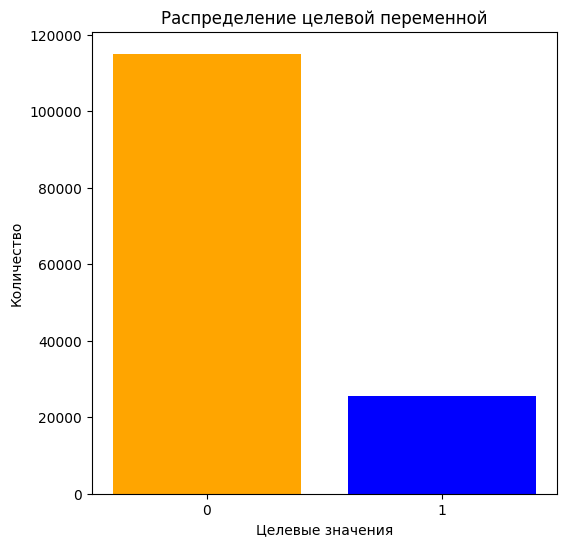

In [76]:
# Посмотрим на распределение числовой переменной
class_counts = df['Depression'].value_counts().loc[lambda x: x.index.isin([0, 1])]

# Создаем столбчатую диаграмму
plt.figure(figsize=(6, 6))
plt.bar(class_counts.index, class_counts, color=['orange', 'blue'])

# Добавляем подписи и заголовок
plt.xlabel('Целевые значения')
plt.ylabel('Количество')
plt.title('Распределение целевой переменной')

# Убедимся, что ось X ограничена только 0 и 1
plt.xticks([0, 1])

# Показываем диаграмму
plt.show()

Имеется дисбаланс классов. Это необходимо учесть в дальнейшем

### **4.2. Распределение числовых значений**

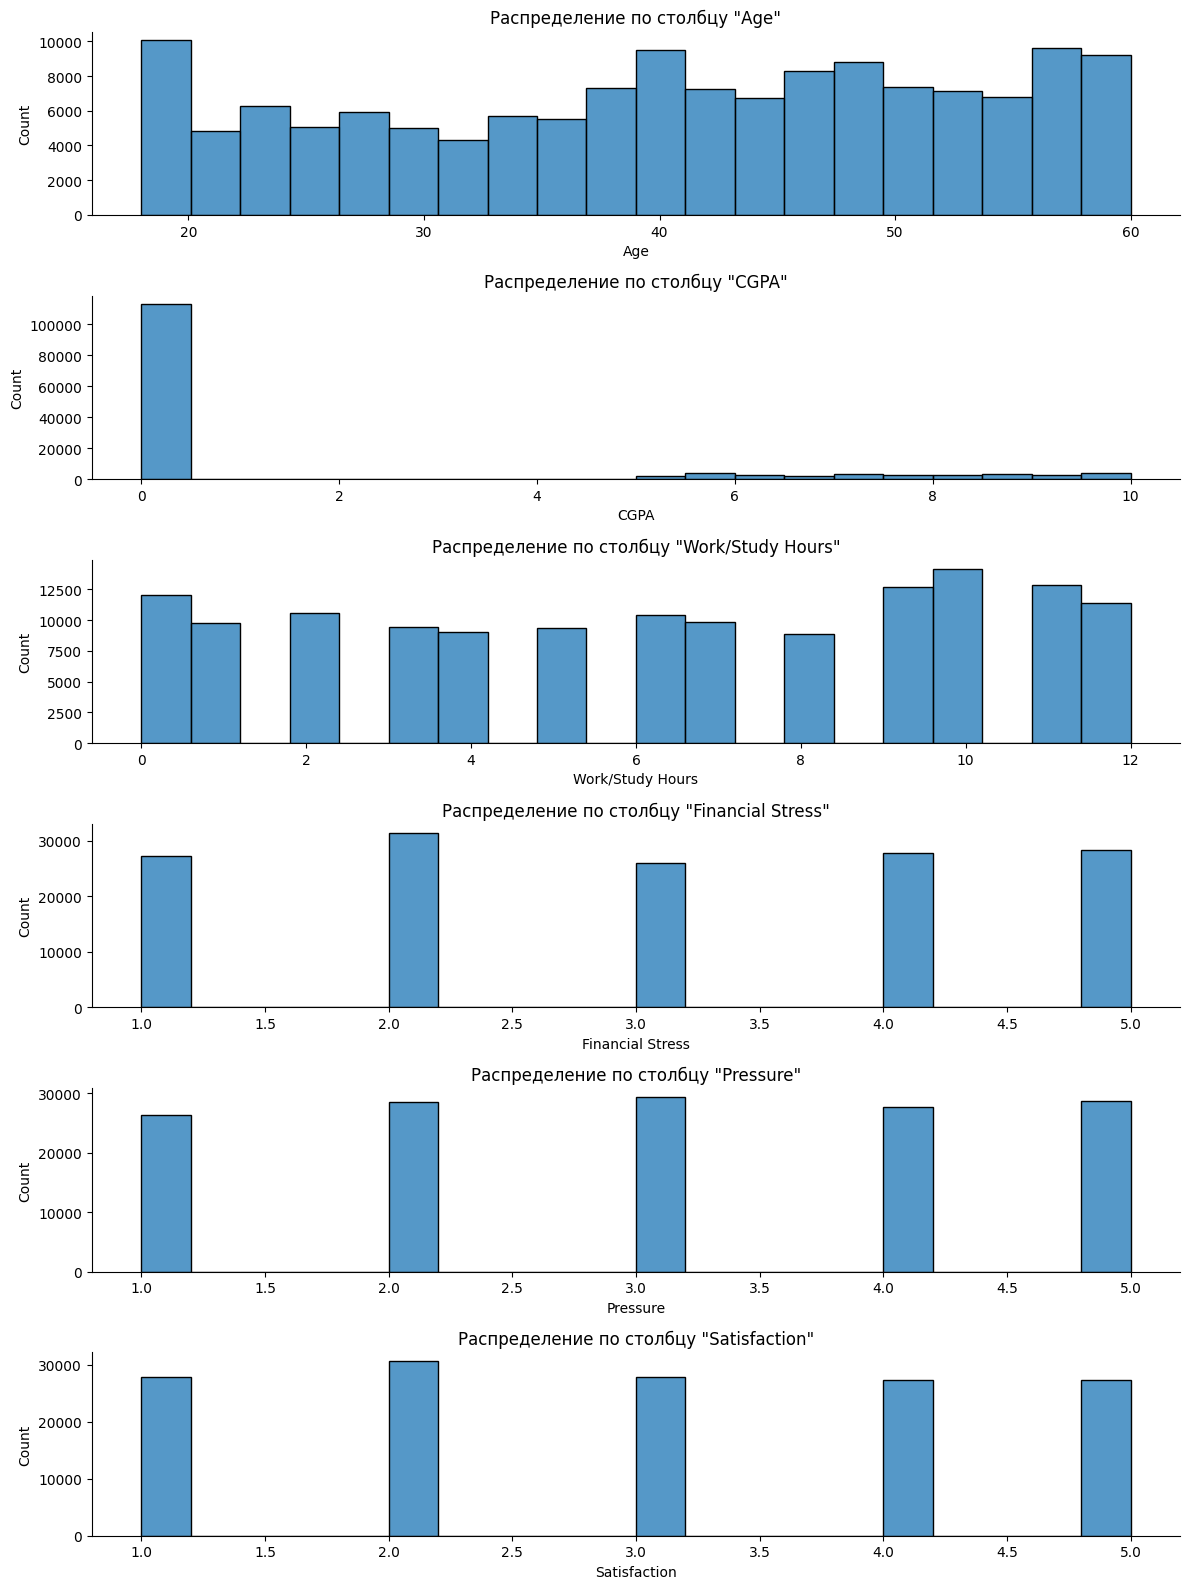

In [77]:
numerical_columns_to_plot = ["Age", "CGPA", "Work/Study Hours", 'Financial Stress', 'Pressure', 'Satisfaction']

plt.figure(figsize=(12, 16))

for i, column in enumerate(numerical_columns_to_plot):
    plt.subplot(6, 1, i+1)
    sns.histplot(data=df, x=column, kde=False, bins=20, color='#1c76b6')
    plt.title(f'Распределение по столбцу "{column}"')
    sns.despine()

plt.tight_layout()
plt.show()

На представленных графиках видно следующее:

1. Возраст участников опроса имеет равномерное распределение. Наблюдаются незначительные пики около 20,40 и 60 лет.

2. Средний балл успеваемости (CGPA) имеет ярко выраженный дисбаланс нулевых значений. Скорее всего, такие значения указаны у рабочих. Необходимо рассмотреть распределение этих значений только у студентов.

3. Остальные графики имеют равномерное распределение.



---


Отдельно рассотрим распределение успеваемости для студентов

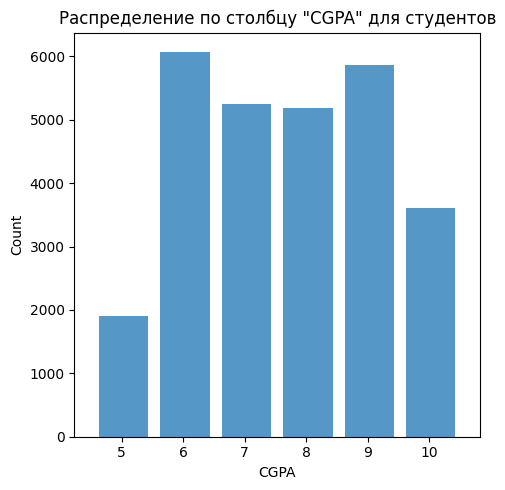

In [78]:
# Создаем гистограмму
plt.figure(figsize=(5, 5))
ax = sns.histplot(
    data=df[df['Working Professional or Student'] == 'Student'],
    x="CGPA", kde=False, bins=5, color='#1c76b6', edgecolor='none',
    linewidth=2, discrete=True
)

# Добавляем промежутки между столбцами
for p in ax.patches:
    p.set_width(0.8)  # Уменьшаем ширину столбцов
    p.set_x(p.get_x() + 0.1)  # Добавляем промежутки (по оси X)

# Настраиваем внешний вид
plt.title('Распределение по столбцу "CGPA" для студентов')
plt.tight_layout()
plt.show()


Гистограмма указывает на то, что большинство студентов имеют CGPA в пределах 6-9, что может свидетельствовать о нормальном распределении оценок среди студентов.

### **4.3. Распределение категориальных значений**

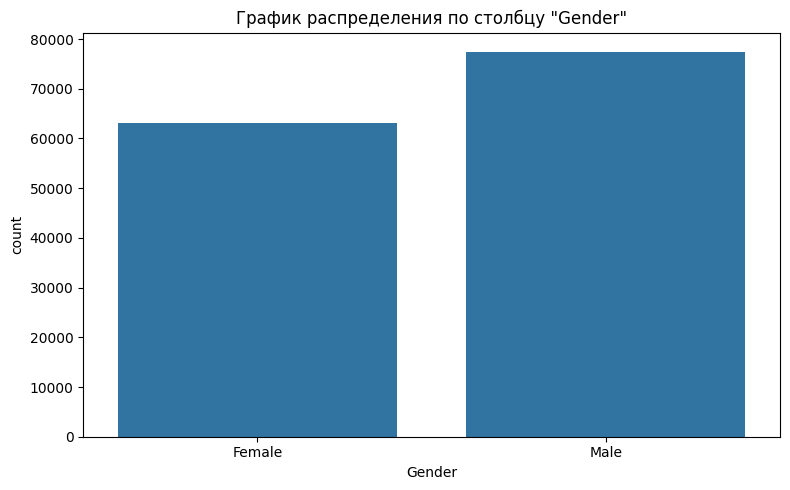

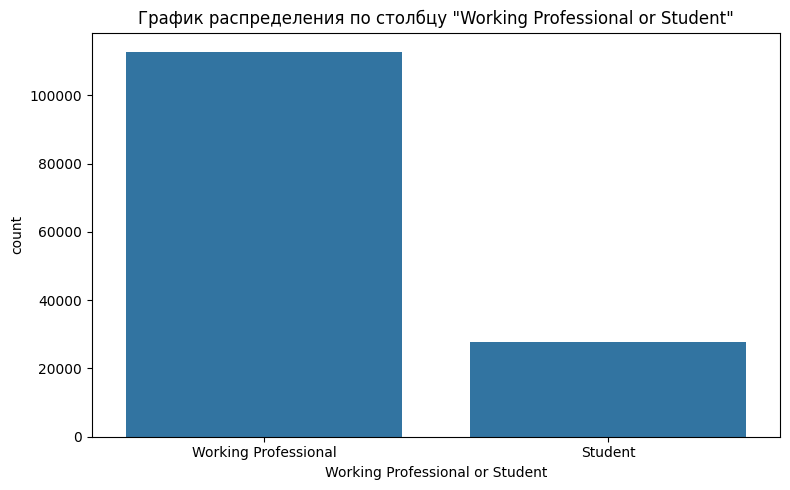

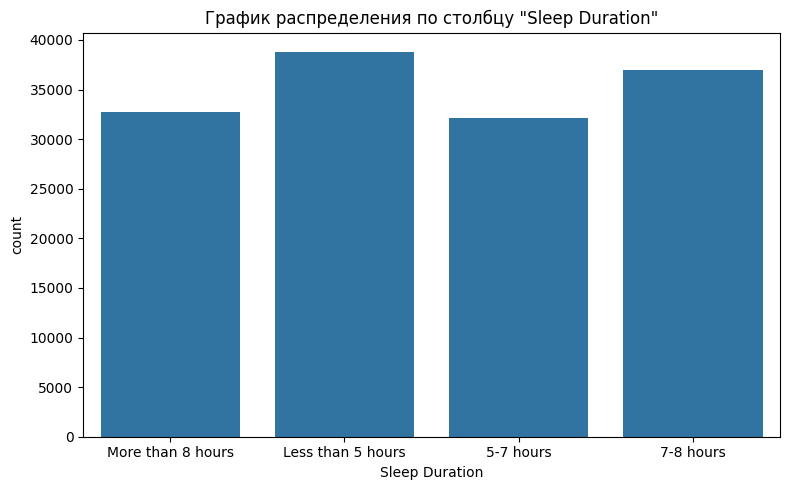

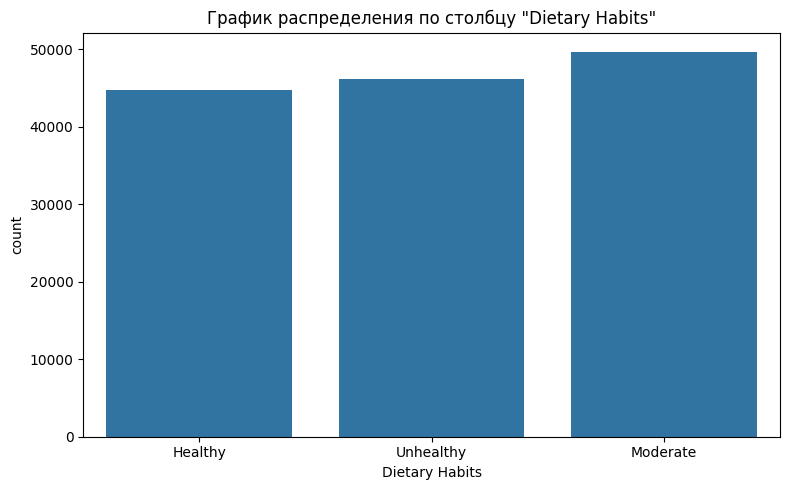

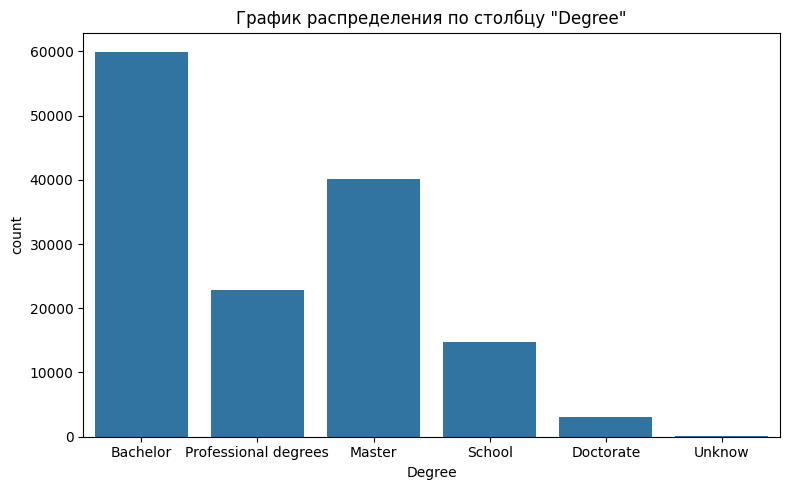

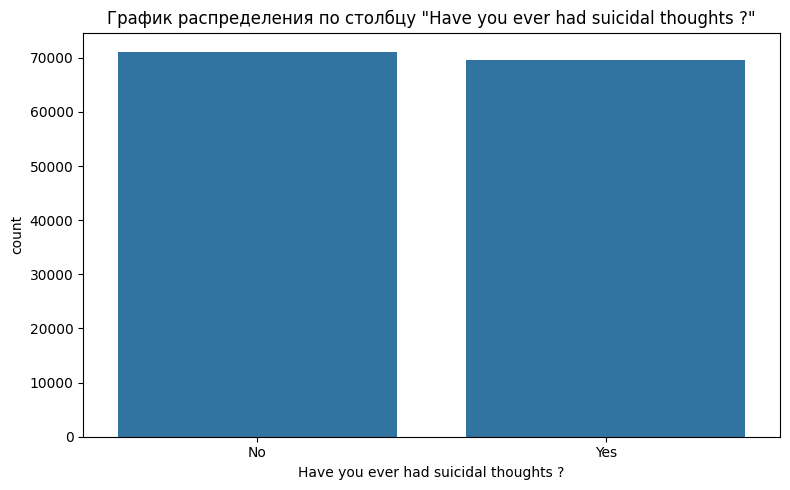

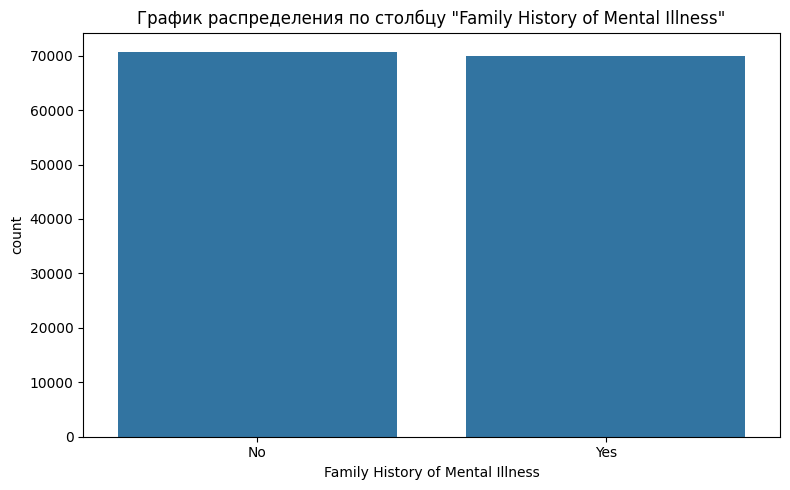

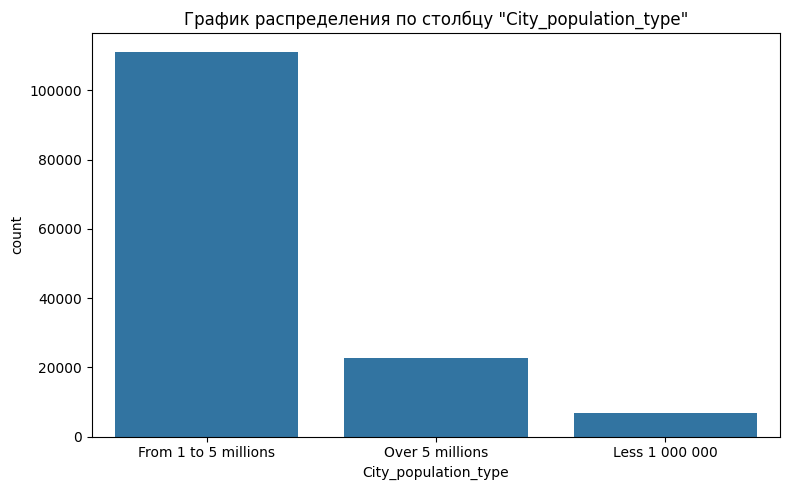

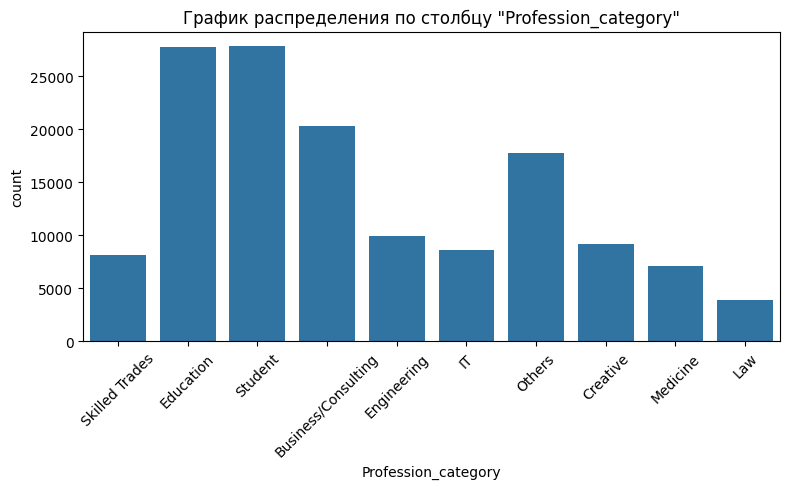

In [79]:
categorical_columns_to_plot = ['Gender', 'Working Professional or Student', 'Sleep Duration',
                       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
                               'Family History of Mental Illness',
                               'City_population_type', 'Profession_category']

# Строим графики для каждого столбца
for column in categorical_columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=column)
    plt.title(f'График распределения по столбцу "{column}"')

    # Если столбец — 'Profession_category', наклоняем метки на оси X на 45 градусов, т.к. значений много
    if column == 'Profession_category':
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Значения в столбцах **'Gender', 'Sleep Duration', 'Dietary Habits',  'Have you ever had suicidal thoughts ?','Financial Stress', 'Family History of Mental Illness'** имеют равномерное распределение.

В столбце **'Working Professional or Student'** имеется сильный дисбаланс в сторону рабочих.

Участники опроса в большинстве своем имеют степень образования бакалавриат и магистратура и живут в городах с населением от 1 до 5 млн.

В опросе больше всего участвовало работников в области образования и бизнес/консалтинге.

### **4.4. Распределения числовых признаков в зависимости от целевой переменной**

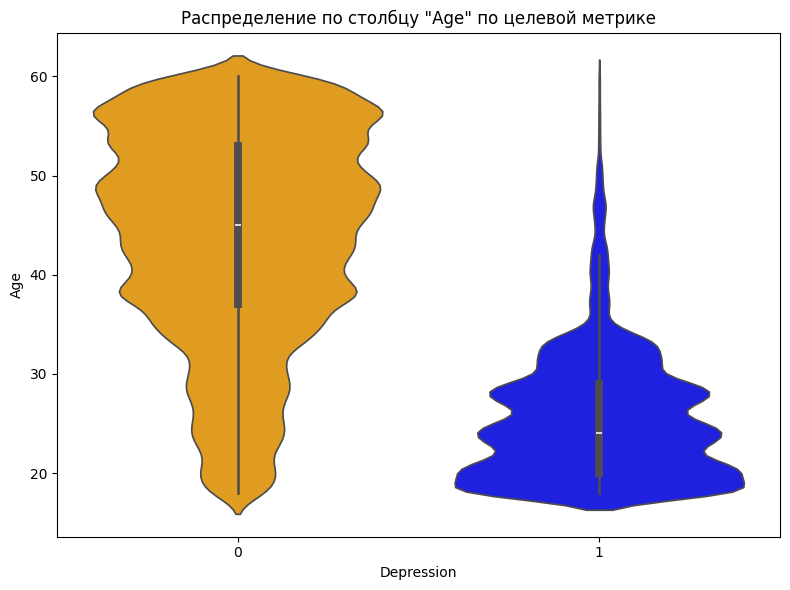

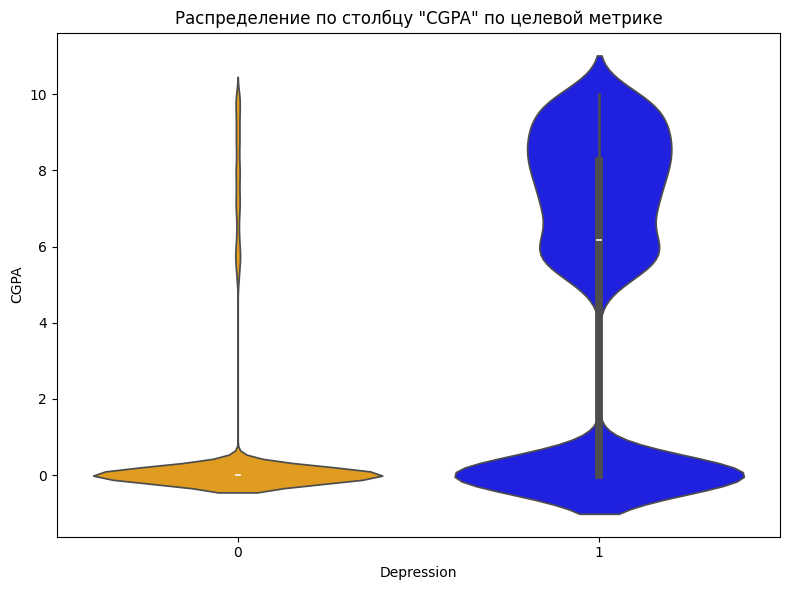

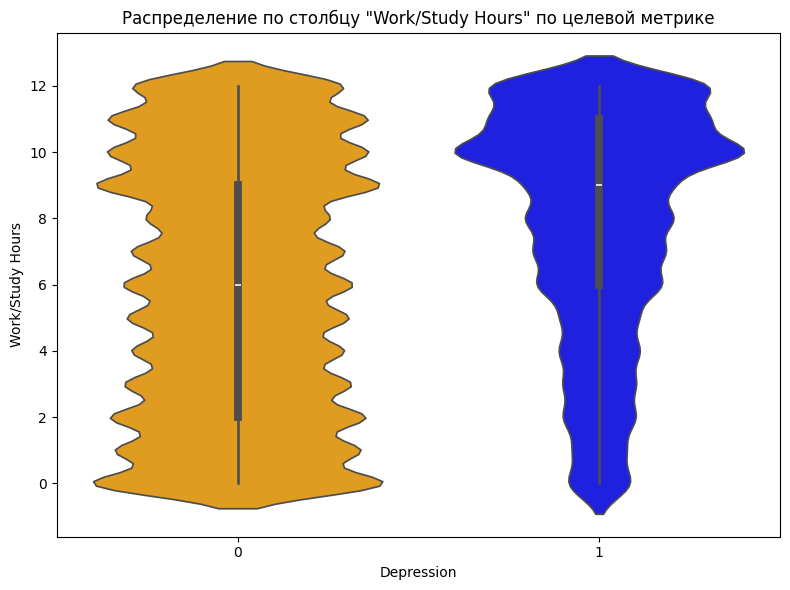

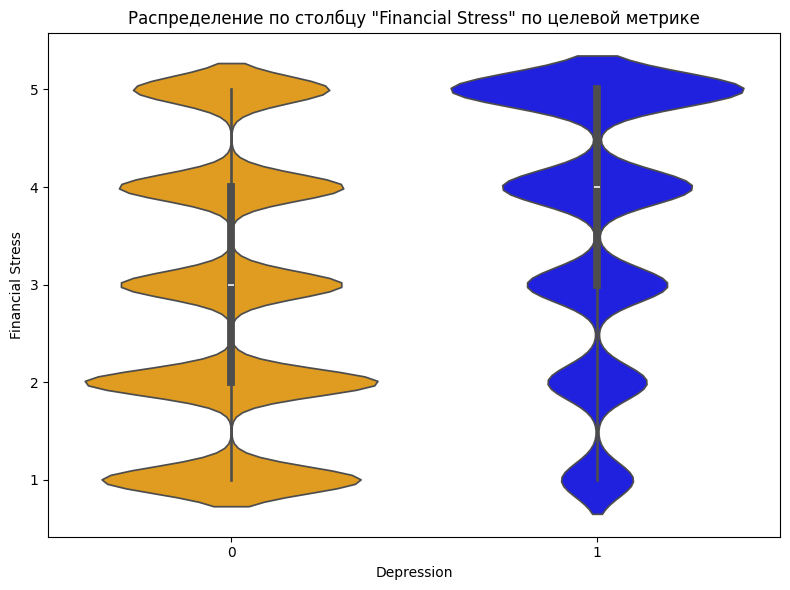

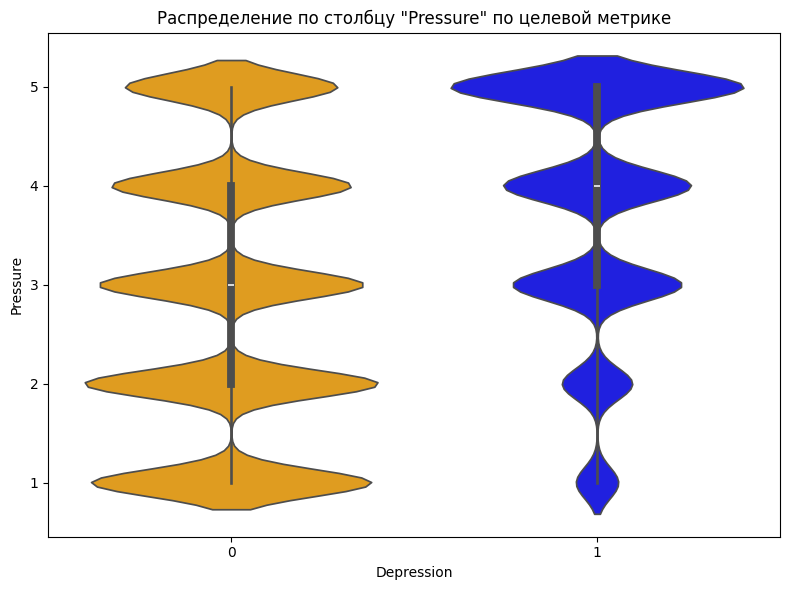

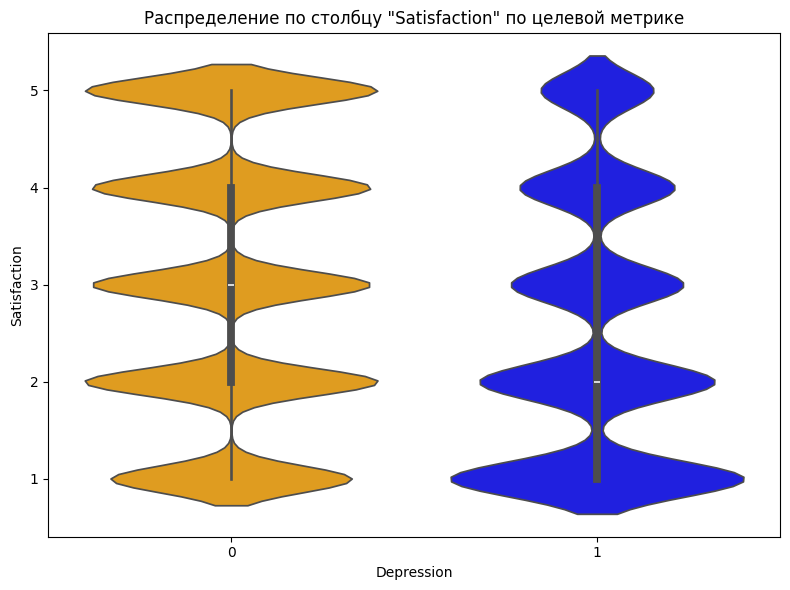

In [80]:
for column in numerical_columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df, x='Depression', y=column, palette=['orange', 'blue'])
    plt.title(f'Распределение по столбцу "{column}" по целевой метрике')

    plt.tight_layout()
    plt.show()

На графике распределения по годам видно, что молодые люди больше подвержены депрессии.

Значения среднего балла выглядят аномально. Необходимо рассмотреть этот показатель отдельно для студентов.


Также можно наблюдать тенденцию, что с увеличением рабочих/учебных часов увеличивается вероятность депрессии.

Финансовый стресс и нагрузка (с увеличением) также влияют на вероятность возникновения депрессии.



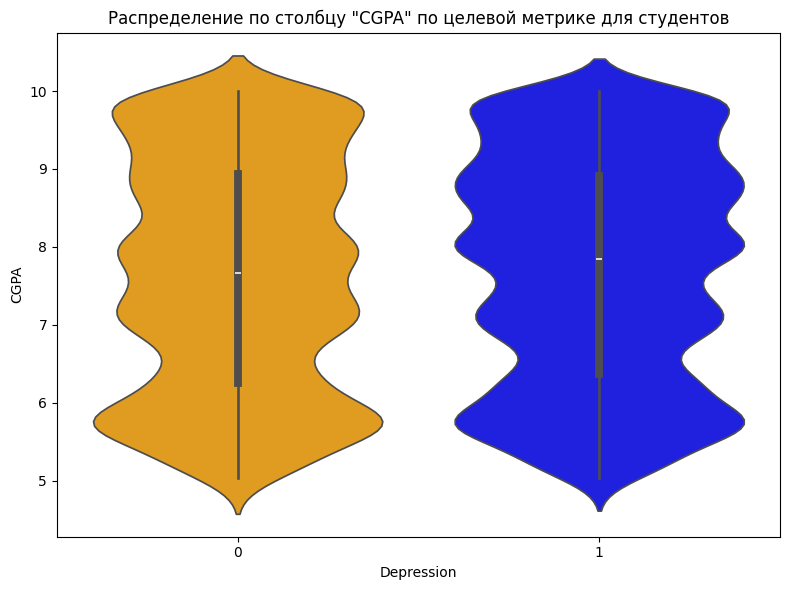

In [81]:
# Расмотрим столбец CGPA только по студентам
plt.figure(figsize=(8, 6))
sns.violinplot(data=df[df['Working Professional or Student'] == 'Student'], x='Depression', y="CGPA", palette=['orange', 'blue'])
plt.title(f'Распределение по столбцу "CGPA" по целевой метрике для студентов')

plt.tight_layout()
plt.show()

Средняя оценка для студентов не влияет на уровень депрессии.

### **4.5. Распределения числовых признаков в зависимости от целевой переменной**

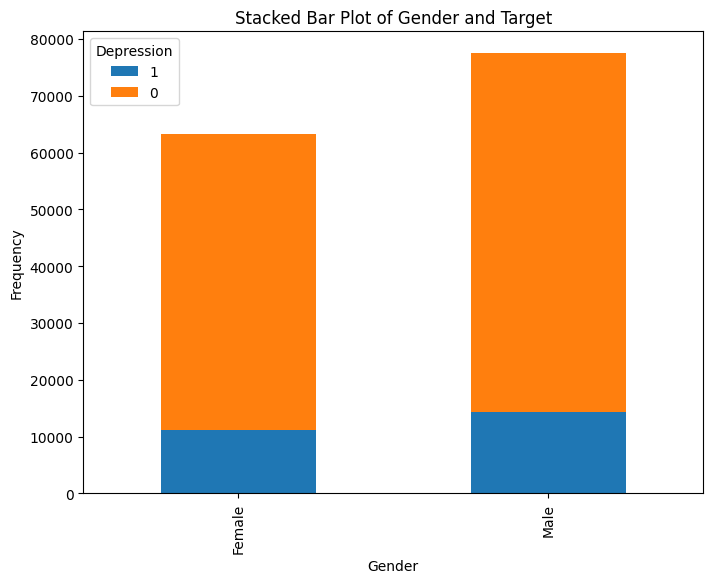

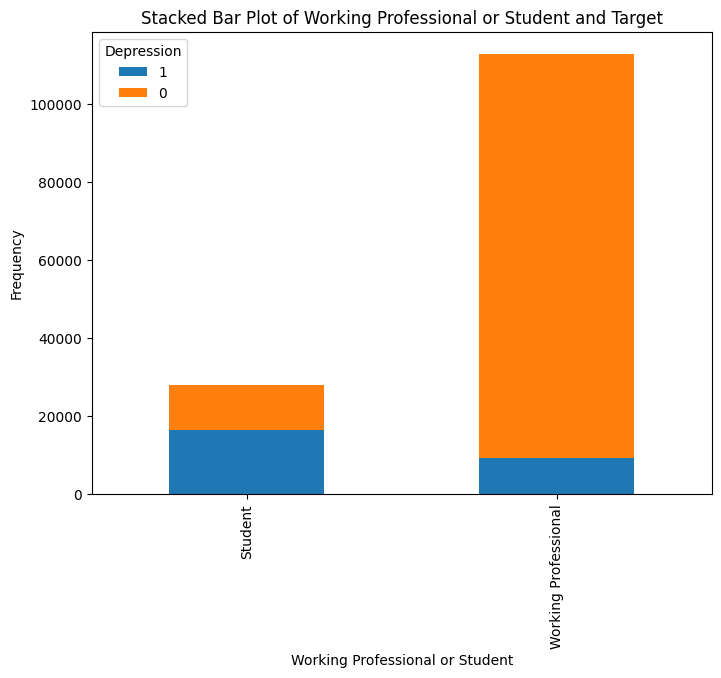

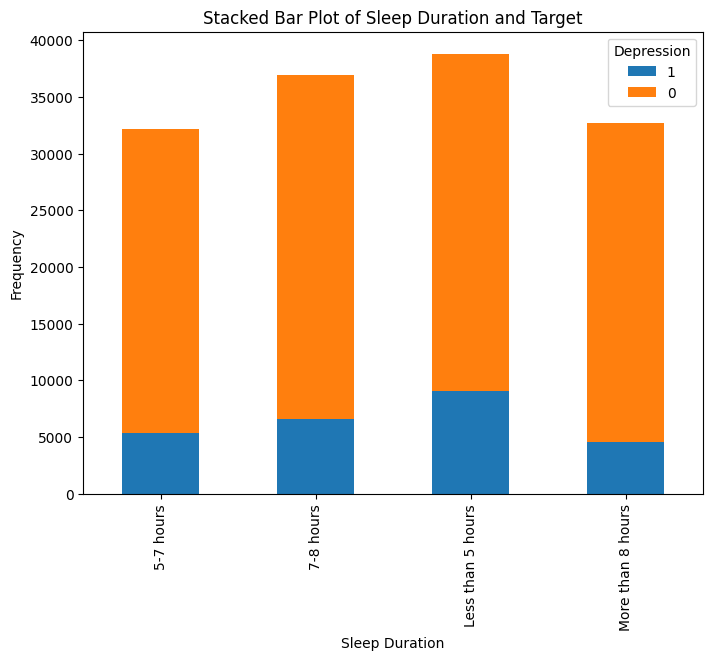

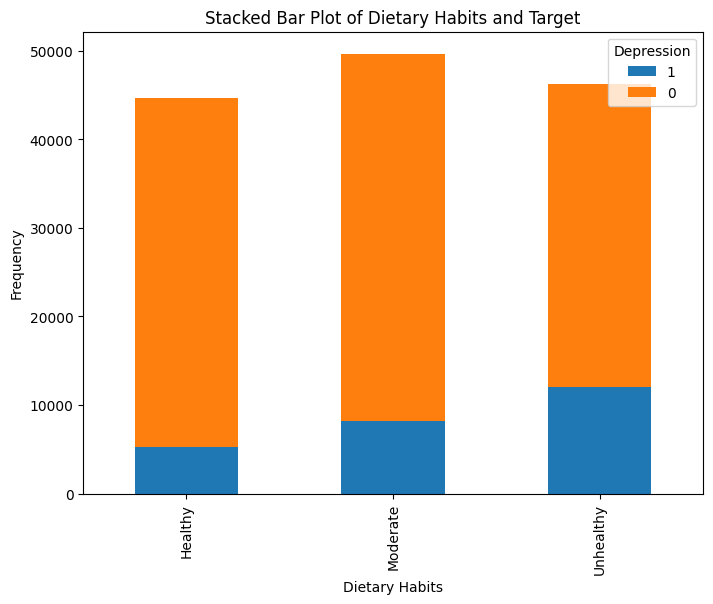

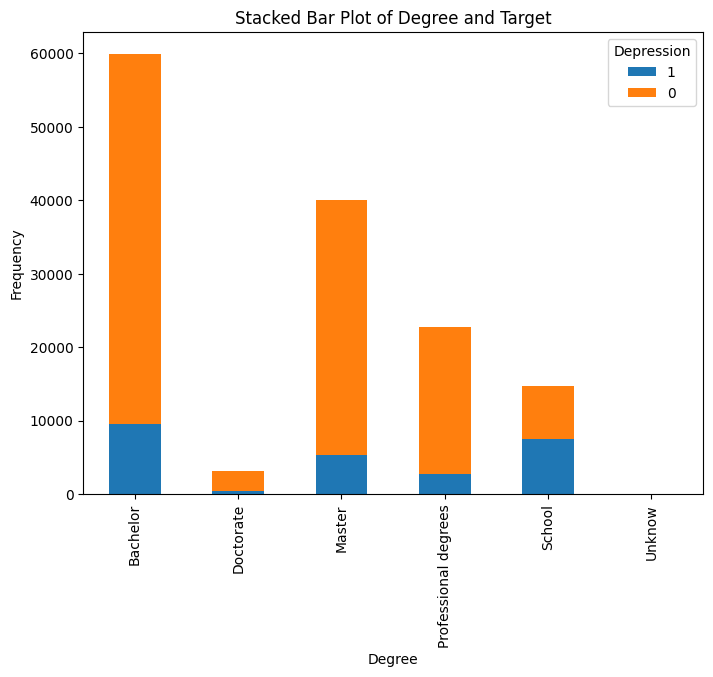

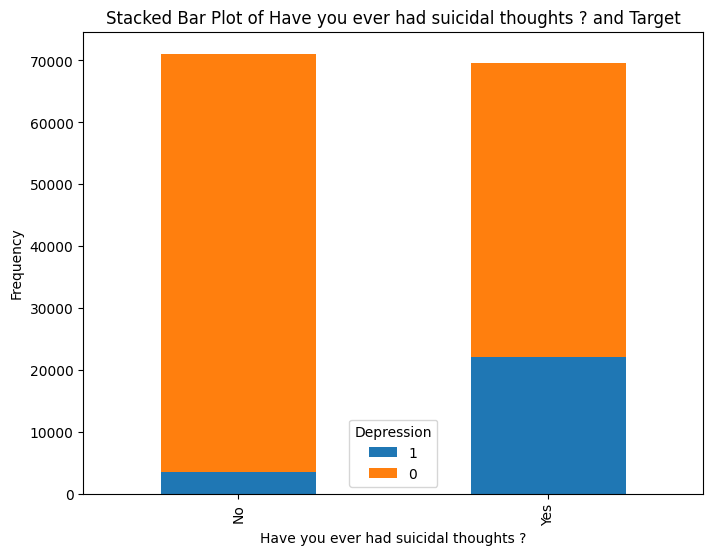

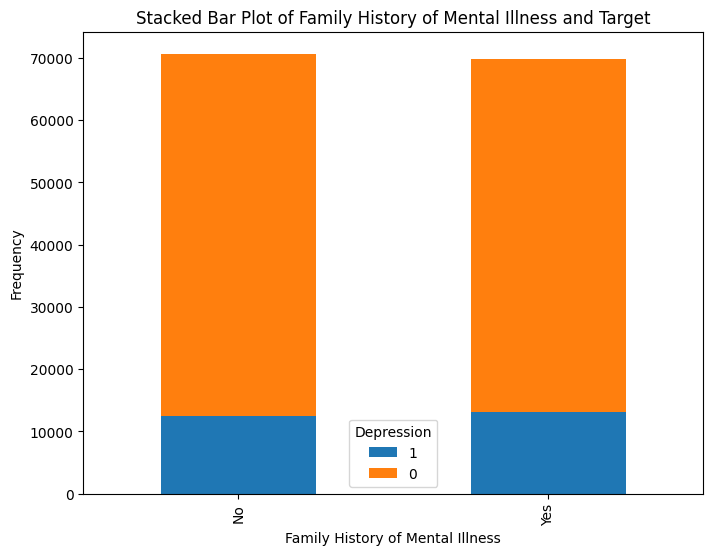

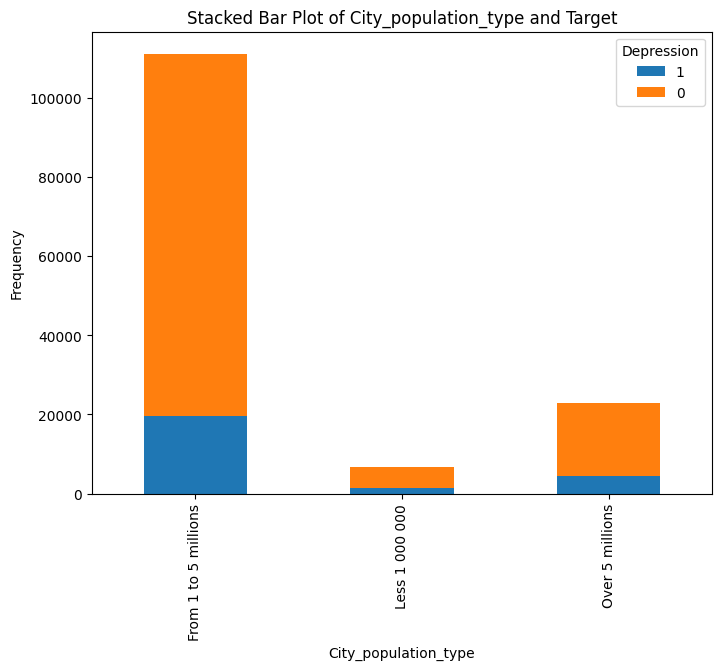

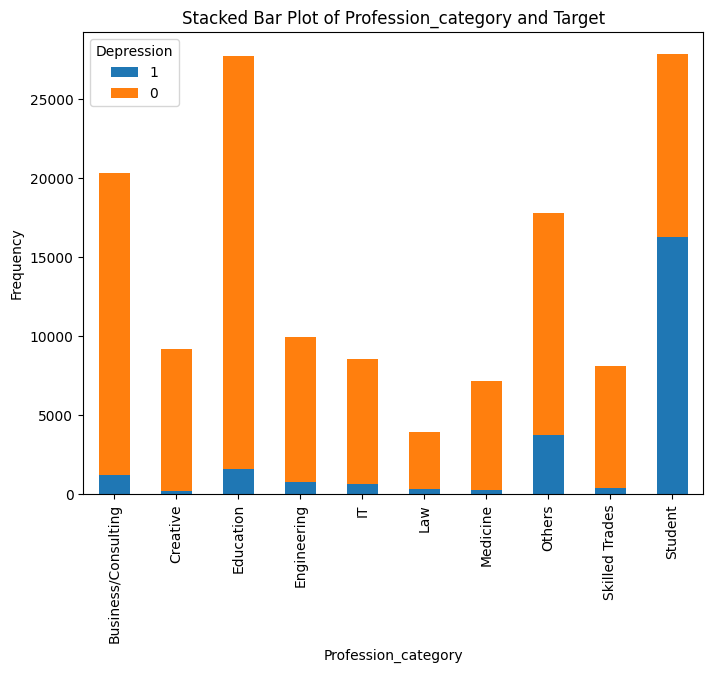

In [82]:
# Построим графики по категориальным признакам
for column in categorical_columns_to_plot:
    # Переворачиваем порядок значений в столбце 'Depression'
    cross_tab = pd.crosstab(df[column], df['Depression'])

    # Переводим столбец 'Depression' так, чтобы 1 был внизу
    cross_tab = cross_tab[[1, 0]]  # Переставляем местами столбцы для '1' и '0'

    # Строим stacked bar plot
    cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6))

    # Настраиваем график
    plt.title(f"Stacked Bar Plot of {column} and Target")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

На графиках подтверждается, что студенты (молодые) склоны к депрессиям. Также более склоны к депрессиям те, кто неправильно питается.
Логичным кажется и то, что те, у кого были мысли о суициде, тоже более склоны к депрессии. Кроме того, недостаток сна тоже влияет на уровень депрессии

### **4.6. Матрица корреляции**

In [83]:
pip install phik

interval columns not set, guessing: ['id', 'Age', 'CGPA', 'Work/Study Hours', 'Financial Stress', 'Depression', 'Pressure', 'Satisfaction', 'Population']


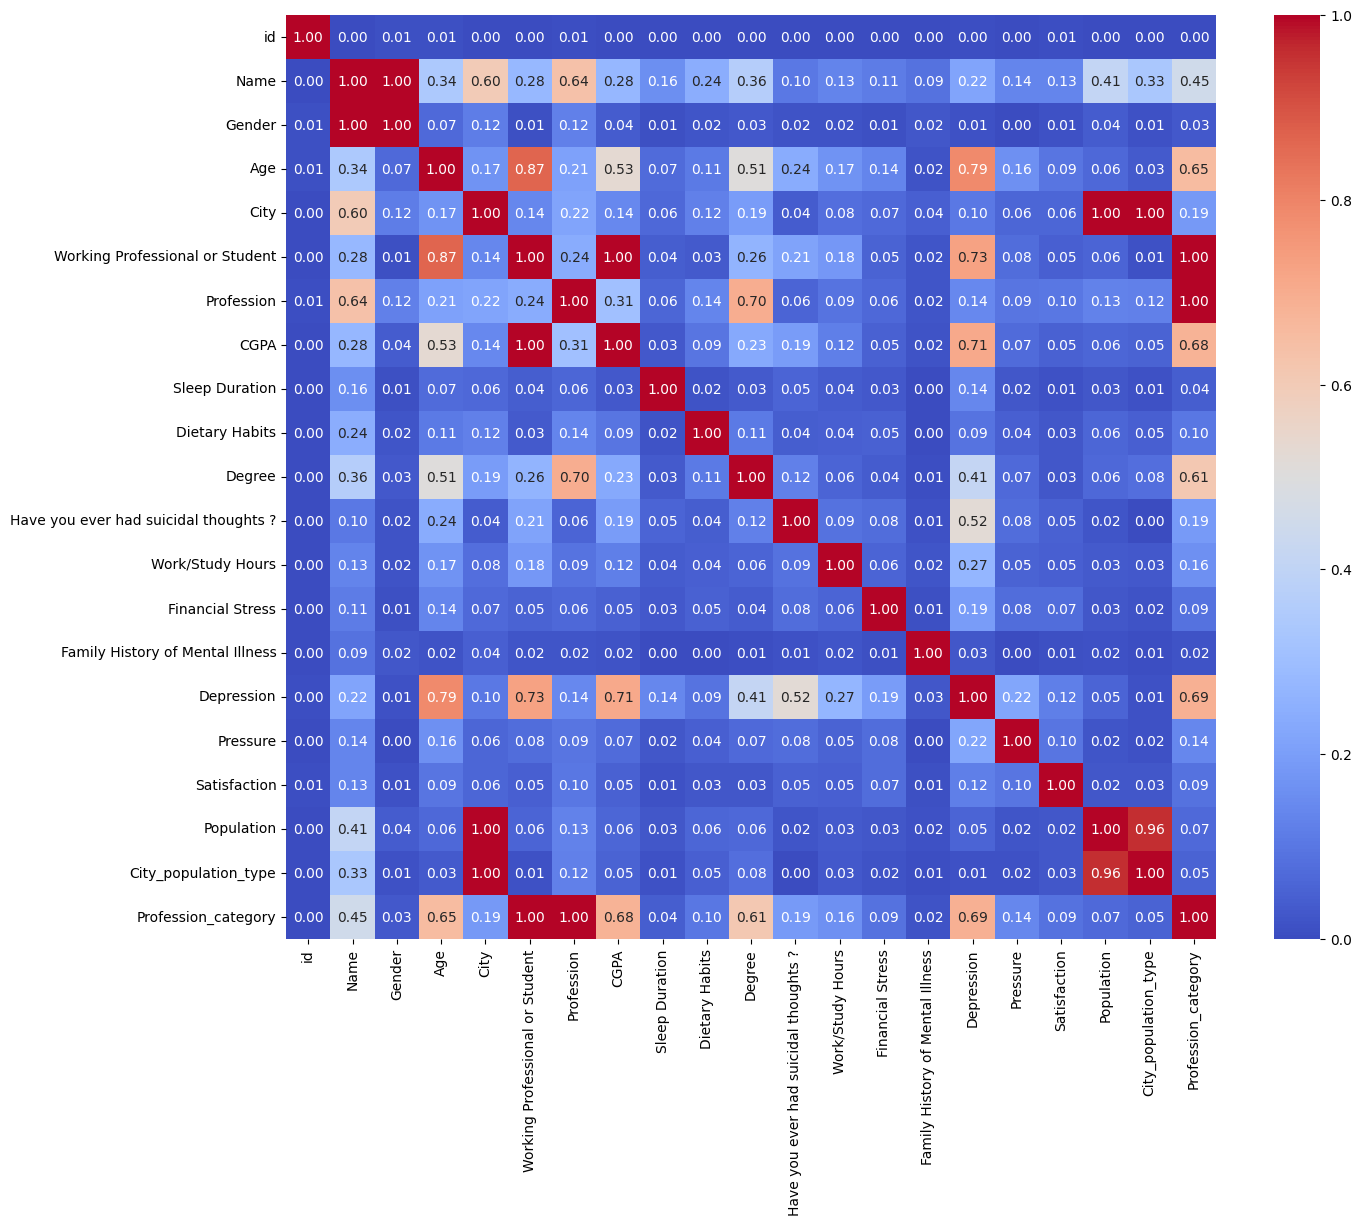

In [85]:
# Строим матрицу корреляции
correlation_matrix = df.phik_matrix()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Матрица подтверждает сильную корреляцию между возрастом и депрессией.
Также имеется сильная корреляция между возрастом и средней оценкой, что было выявленно ранее.
Наблюдается сильная корреляция между столбцами **'Working Professional or Student'** и **'Profession_category'**.

Также видим корреляцию между фактом депресии и столбцами **'Working Professional or Student'** и **'Profession_category'**, что еще раз говорит о том, что студенты более подвержены депрессии.

Также матрица корреляции подтверждает факт взаимосвязи между возникавшими когда-либо суицидальными мыслями и депрессией.

**Вывод**: В результате разведочного анализа данных было выявлено следующее:

1. Имеется дисбаланс классов целевой переменной. Необходимо учесть при обучении.

2. Важными признаками является возвраст, професиия, суицидальные мысли, финансовый стресс и общее напряжение.

3. Наблюдатается мультиколлериарность признаков 'Working Professional or Student' и 'Profession_category', а также 'Age' и 'CGPA'. Необхожимо будет исключить в этих парах один из признаков.

# **5. Препроцессинг**

## **5.1. Выбор признаков**

Предварительно уберем признаки, которые не влияют на обучение, либо которые имеют мультиколениарность с другими признаками

In [86]:
df = df.drop(['id', 'Name', 'City', 'Profession', 'Population', 'Working Professional or Student', 'CGPA'], axis=1)

In [87]:
# Итоговый перечень признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140624 entries, 0 to 140623
Data columns (total 14 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140624 non-null  object 
 1   Age                                    140624 non-null  float64
 2   Sleep Duration                         140624 non-null  object 
 3   Dietary Habits                         140624 non-null  object 
 4   Degree                                 140624 non-null  object 
 5   Have you ever had suicidal thoughts ?  140624 non-null  object 
 6   Work/Study Hours                       140624 non-null  float64
 7   Financial Stress                       140624 non-null  float64
 8   Family History of Mental Illness       140624 non-null  object 
 9   Depression                             140624 non-null  int64  
 10  Pressure                               140624 non-null  

## **5.2. Работа с категориальными признаками**

In [88]:
# С помощью  One-hot encoding преобразуем категориальные переменные в числовые для дальнейшего обучения различных моделей

df = pd.get_dummies(df, columns=['Gender', 'Sleep Duration', 'Dietary Habits',
                                       'Degree', 'Have you ever had suicidal thoughts ?',
                                       'Family History of Mental Illness', 'City_population_type',
                                       'Profession_category'], drop_first=True) # чтобы избежать мультиколлинеарности

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140624 entries, 0 to 140623
Data columns (total 30 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   Age                                        140624 non-null  float64
 1   Work/Study Hours                           140624 non-null  float64
 2   Financial Stress                           140624 non-null  float64
 3   Depression                                 140624 non-null  int64  
 4   Pressure                                   140624 non-null  float64
 5   Satisfaction                               140624 non-null  float64
 6   Gender_Male                                140624 non-null  bool   
 7   Sleep Duration_7-8 hours                   140624 non-null  bool   
 8   Sleep Duration_Less than 5 hours           140624 non-null  bool   
 9   Sleep Duration_More than 8 hours           140624 non-null  bool   
 10  Dietary 

В датасете не осталось текстовых типов данных.

## **5.3. Нормализация данных**

In [90]:
# Применение Min-Max Scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

In [91]:
df

,Age,Work/Study Hours,Financial Stress,Depression,Pressure,Satisfaction,Gender_Male,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Degree_Doctorate,Degree_Master,Degree_Professional degrees,Degree_School,Degree_Unknow,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes,City_population_type_Less 1 000 000,City_population_type_Over 5 millions,Profession_category_Creative,Profession_category_Education,Profession_category_Engineering,Profession_category_IT,Profession_category_Law,Profession_category_Medicine,Profession_category_Others,Profession_category_Skilled Trades,Profession_category_Student
0,0.738095,0.083333,0.25,0.0,1.00,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.190476,0.583333,0.50,1.0,0.75,0.50,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.357143,0.250000,0.00,1.0,1.00,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.095238,0.833333,0.00,1.0,1.00,0.00,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.285714,0.750000,0.75,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140619,0.000000,0.166667,0.75,1.0,1.00,0.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
140620,0.547619,0.500000,1.00,0.0,1.00,0.75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140621,0.142857,0.333333,0.75,0.0,0.50,0.00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140622,0.738095,0.833333,0.00,0.0,1.00,0.25,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Числовые данные нормализованы.

# **6. Выбор модели**

In [93]:
# Разделим данные на тренировочную и тестовую выборки с учетом стратификации
X = df.drop('Depression', axis=1)
y = df['Depression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [94]:
# Создаём пустую таблицу для метрик
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

In [95]:
# Напишем функцию для выбора основной модели
def evaluate_model(model, X_train, y_train, X_test, y_test):

    global metrics_df

    # Обучение модели
    model.fit(X_train, y_train)

    # Прогнозирование
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Оценка модели
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Вывод метрик
    print(f"Метрики качества для модели {type(model).__name__}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Добавление метрик в сводную таблицу
    metrics_dict = {
        'Model': type(model).__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    # Добавляем метрики в таблицу
    metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics_dict])], ignore_index=True)

## **6.1. LogisticRegression (Baseline)**

В качестве baseline возмем модель логистической регресии

Метрики качества для модели LogisticRegression:
Accuracy: 0.9121
Precision: 0.6926
Recall: 0.9283
F1-Score: 0.7933
ROC-AUC: 0.9731


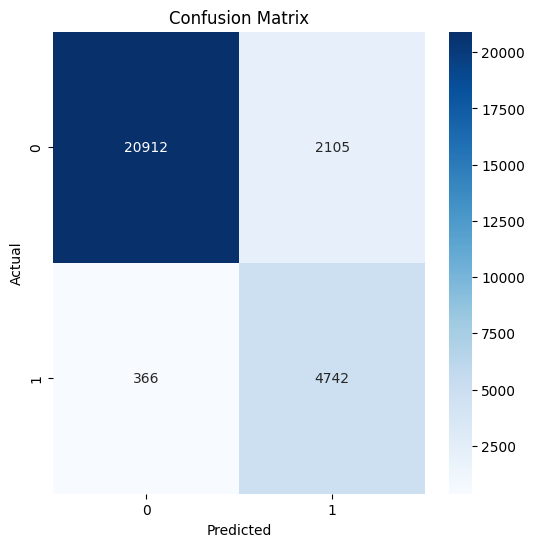

In [96]:
lr_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
evaluate_model(lr_model, X_train, y_train, X_test, y_test)

## **6.2. Random Forest**

Метрики качества для модели RandomForestClassifier:
Accuracy: 0.9348
Precision: 0.8510
Recall: 0.7768
F1-Score: 0.8122
ROC-AUC: 0.9703


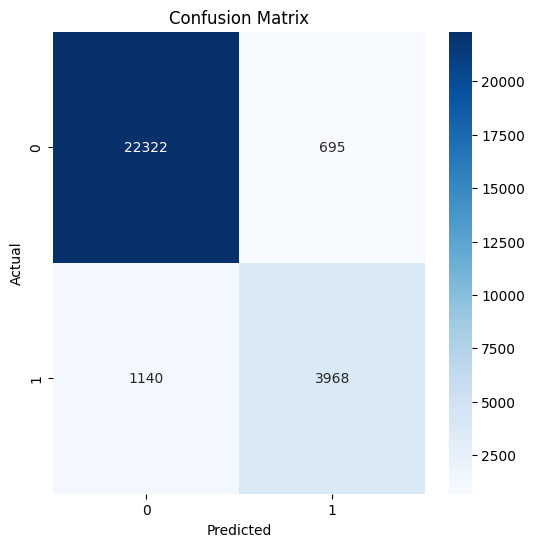

In [97]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

## **6.3. LightGBM**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Метрики качества для модели LGBMClassifier:
Accuracy: 0.9174
Precision: 0.7086
Recall: 0.9264
F1-Score: 0.8030
ROC-AUC: 0.9739


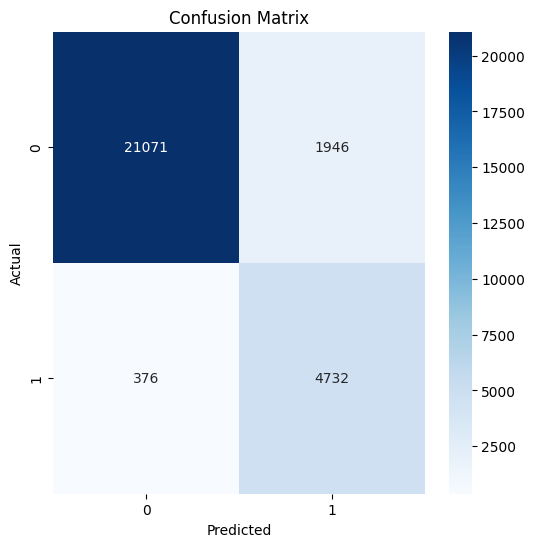

In [98]:
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42, verbose=0)
evaluate_model(lgb_model, X_train, y_train, X_test, y_test)


## **6.4. XGBoost**

Метрики качества для модели XGBClassifier:
Accuracy: 0.9377
Precision: 0.8378
Recall: 0.8150
F1-Score: 0.8262
ROC-AUC: 0.9727


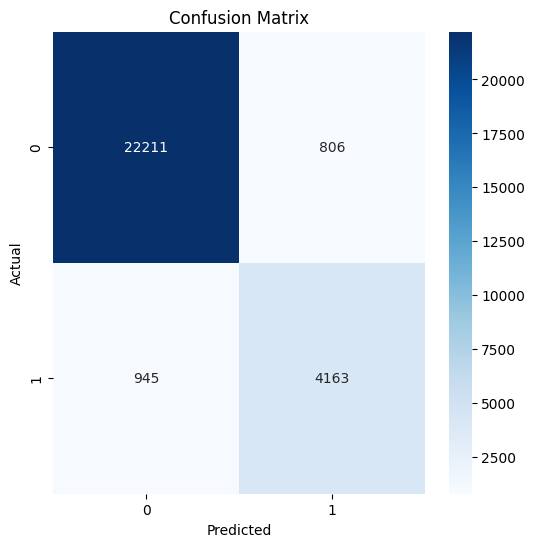

In [99]:
xgb_model = xgb.XGBClassifier(random_state=42)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)




---



In [100]:
# Сравним показатели метрик моделей
metrics_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,LogisticRegression,0.912142,0.692566,0.928348,0.793308,0.973078
1,RandomForestClassifier,0.934756,0.850954,0.776821,0.812199,0.970314
2,LGBMClassifier,0.917440,0.708595,0.926390,0.802987,0.973950
3,XGBClassifier,0.937742,0.837794,0.814996,0.826238,0.972666


**Вывод**:

Показатели моделей RandomForestClassifier, LGBMClassifier, XGBClassifier лучше показателей нашей baseline-модели (LogisticRegression), поэтому все они прошли проверку на адекватность.

Лучше всего себя показала модель XGBClassifier по всем метрикам.

В нашей задаче важно не пропустить людей с депрессией, поэтому метрика recall будет иметь большее значение. Но также нам важен баланс, поэтому также важно учесть метрику f1-score.

Поэтому на втором месте у нас модель LGBMClassifier, а на третьем RandomForestClassifier.

Рассмотрим как мы можем улучшить каждую из моделей.




# **7.Обучение моделей**

Попробуем улучшить качество каждой из моделей, потому что все они показали хорошие результаты при предварительной оценке.

## **7.1. Подбор наилучших гиперпараметров**

Подбор гиперпараметров будем осуществлять с помощью **Optuna**

In [102]:
# Создадим функцию для подбора гиперпараметров с помощью Optuna
def tune_model_optuna(model_class, param_distributions, X_train, y_train, cv_folds=5, scoring='f1', n_trials=50):
    """
    Универсальная функция для подбора гиперпараметров с помощью Optuna.

    Параметры:
    model_class - класс модели
    param_distributions - словарь с диапазонами значений гиперпараметров (Optuna trial)
    X_train - обучающие данные
    y_train - метки обучающих данных
    cv_folds - количество фолдов для кросс-валидации (по умолчанию 5)
    scoring - метрика для оценки модели (по умолчанию F1-Score)
    n_trials - количество итераций для Optuna (по умолчанию 50)
    """

    def objective(trial):
        # Создаем словарь гиперпараметров из param_distributions
        params = {key: func(trial) for key, func in param_distributions.items()}

        # Инициализируем модель с заданными параметрами
        model = model_class(**params)

        # Используем StratifiedKFold для кросс-валидации
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

        # Оцениваем модель по F1-Score с кросс-валидацией
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(f1_score))

        return scores.mean()

    # Создаем Optuna study и запускаем оптимизацию
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    # Выводим результаты
    print(f"Лучшие параметры для модели {model_class.__name__}: {study.best_params}")
    print(f"Лучший F1-Score: {study.best_value}")

    return study.best_params

#### **7.1. XGBoost**

In [111]:
# Определяем гиперпараметры для XGBoost
param_distributions_xgb = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 50, 500),
    "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 15),
    "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
    "subsample": lambda trial: trial.suggest_float("subsample", 0.5, 1.0),
    "colsample_bytree": lambda trial: trial.suggest_float("colsample_bytree", 0.5, 1.0),
    "gamma": lambda trial: trial.suggest_float("gamma", 0, 5),
    "reg_alpha": lambda trial: trial.suggest_float("reg_alpha", 0.0, 10.0),
    "reg_lambda": lambda trial: trial.suggest_float("reg_lambda", 0.0, 10.0),
    "scale_pos_weight": lambda trial: trial.suggest_float("scale_pos_weight", 0.0, 10.0)
}

# Запускаем Optuna для XGBoost
best_params_xgb = tune_model_optuna(xgb.XGBClassifier, param_distributions_xgb, X_train, y_train)


[I 2025-02-04 12:54:52,983] A new study created in memory with name: no-name-cf1ecb62-c02c-46e3-a49f-f677edef87ff
[I 2025-02-04 12:55:49,831] Trial 0 finished with value: 0.7877841362341829 and parameters: {'n_estimators': 273, 'max_depth': 9, 'learning_rate': 0.08634852720643726, 'subsample': 0.6239823057009708, 'colsample_bytree': 0.6437117009053572, 'gamma': 1.8826303370419422, 'reg_alpha': 6.003621417984001, 'reg_lambda': 8.120975438237357, 'scale_pos_weight': 8.183158583386046}. Best is trial 0 with value: 0.7877841362341829.
[I 2025-02-04 12:56:31,264] Trial 1 finished with value: 0.817241280461731 and parameters: {'n_estimators': 432, 'max_depth': 13, 'learning_rate': 0.1496010264738117, 'subsample': 0.780855797306532, 'colsample_bytree': 0.6411177185726404, 'gamma': 0.13078319047290066, 'reg_alpha': 1.533899876975543, 'reg_lambda': 7.904127540911823, 'scale_pos_weight': 3.881573999745985}. Best is trial 1 with value: 0.817241280461731.
[I 2025-02-04 12:56:37,462] Trial 2 finish

Лучшие параметры для модели XGBClassifier: {'n_estimators': 356, 'max_depth': 3, 'learning_rate': 0.2922171268845925, 'subsample': 0.8388052800473362, 'colsample_bytree': 0.8659491833064125, 'gamma': 2.7404969736541505, 'reg_alpha': 6.874753639763085, 'reg_lambda': 6.077538671858536, 'scale_pos_weight': 1.8769946065445122}
Лучший F1-Score: 0.8324959638703863


Метрики качества для модели XGBClassifier:
Accuracy: 0.9360
Precision: 0.7933
Recall: 0.8761
F1-Score: 0.8326
ROC-AUC: 0.9746


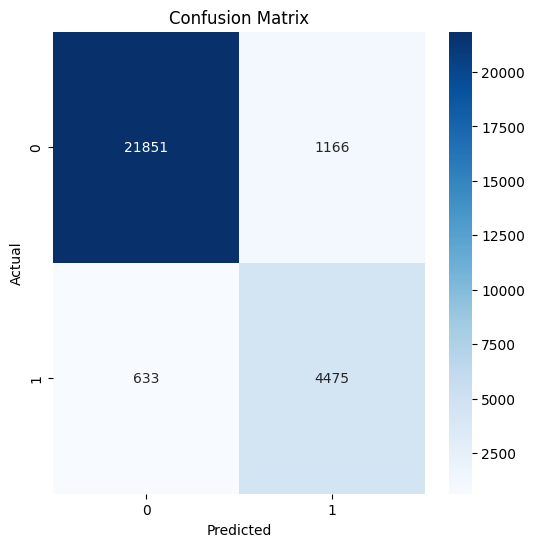

In [112]:
xgb_model = xgb.XGBClassifier(**best_params_xgb, random_state=42)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

#### **7.2. LightGBM**

In [105]:
# Определяем гиперпараметры для LightGBM
param_distributions_lgbm = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 50, 500),
    "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 15),
    "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
    "num_leaves": lambda trial: trial.suggest_int("num_leaves", 20, 150),
    "min_child_samples": lambda trial: trial.suggest_int("min_child_samples", 5, 100),
    "subsample": lambda trial: trial.suggest_float("subsample", 0.5, 1.0),
    "colsample_bytree": lambda trial: trial.suggest_float("colsample_bytree", 0.5, 1.0),
    "reg_alpha": lambda trial: trial.suggest_float("reg_alpha", 0.0, 10.0),
    "reg_lambda": lambda trial: trial.suggest_float("reg_lambda", 0.0, 10.0),
    "class_weight": lambda trial: trial.suggest_categorical("class_weight", ['balanced'])
}

# Запускаем Optuna для LightGBM
best_params_lgbm = tune_model_optuna(lgb.LGBMClassifier, param_distributions_lgbm, X_train, y_train)

[I 2025-02-04 11:58:32,472] A new study created in memory with name: no-name-7bffa357-493a-41ef-af11-0073c990448d
[I 2025-02-04 11:58:44,937] Trial 0 finished with value: 0.8026835277542734 and parameters: {'n_estimators': 117, 'max_depth': 13, 'learning_rate': 0.12666473453679378, 'num_leaves': 25, 'min_child_samples': 11, 'subsample': 0.6015378379294036, 'colsample_bytree': 0.6495284815083884, 'reg_alpha': 0.8844083200760411, 'reg_lambda': 5.733425993994789, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8026835277542734.
[I 2025-02-04 11:58:45,501] Trial 1 finished with value: 0.8051125065566745 and parameters: {'n_estimators': 106, 'max_depth': 9, 'learning_rate': 0.13659825358556468, 'num_leaves': 88, 'min_child_samples': 93, 'subsample': 0.6877806512860117, 'colsample_bytree': 0.848608462420932, 'reg_alpha': 1.8789937595584472, 'reg_lambda': 5.304887255095797, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8051125065566745.
[I 2025-02-04 11:58:52,270] Tria

Лучшие параметры для модели LGBMClassifier: {'n_estimators': 298, 'max_depth': 11, 'learning_rate': 0.2609796607926776, 'num_leaves': 133, 'min_child_samples': 42, 'subsample': 0.7185530835142989, 'colsample_bytree': 0.7428046070148981, 'reg_alpha': 0.05096606316225949, 'reg_lambda': 7.621881282417373, 'class_weight': 'balanced'}
Лучший F1-Score: 0.8145113130645253


Метрики качества для модели LGBMClassifier:
Accuracy: 0.9255
Precision: 0.7491
Recall: 0.8866
F1-Score: 0.8121
ROC-AUC: 0.9708


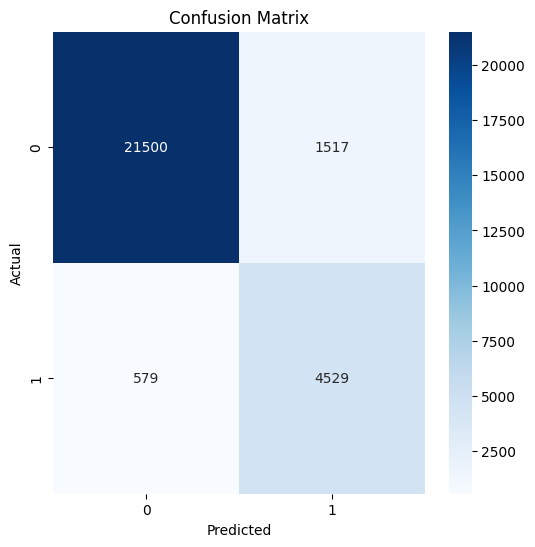

In [106]:
lgb_model = lgb.LGBMClassifier(**best_params_lgbm, random_state=42, verbosity=-1)
evaluate_model(lgb_model, X_train, y_train, X_test, y_test)

#### **7.3. Random Forest**

In [107]:
# Определяем гиперпараметры с Optuna
param_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 10, 300),
    "max_depth": lambda trial: trial.suggest_int("max_depth", 2, 20),
    "min_samples_split": lambda trial: trial.suggest_int("min_samples_split", 2, 20),
    "min_samples_leaf": lambda trial: trial.suggest_int("min_samples_leaf", 1, 20),
    "bootstrap": lambda trial: trial.suggest_categorical("bootstrap", [True, False]),
    "class_weight": lambda trial: trial.suggest_categorical("class_weight", ['balanced'])
}

# Запускаем подбор гиперпараметров
best_params_rf = tune_model_optuna(RandomForestClassifier, param_distributions, X_train, y_train)

[I 2025-02-04 12:13:46,599] A new study created in memory with name: no-name-460bc6ae-4897-4743-8245-ae1f2e63d1ee
[I 2025-02-04 12:14:29,392] Trial 0 finished with value: 0.7232435347154313 and parameters: {'n_estimators': 146, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 13, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7232435347154313.
[I 2025-02-04 12:15:50,281] Trial 1 finished with value: 0.7995243761066858 and parameters: {'n_estimators': 148, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 14, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7995243761066858.
[I 2025-02-04 12:16:04,697] Trial 2 finished with value: 0.79859215835001 and parameters: {'n_estimators': 206, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 14, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7995243761066858.
[I 2025-02-04 12:16:34,345] Trial 4 finished with value: 0.771

Лучшие параметры для модели RandomForestClassifier: {'n_estimators': 128, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'class_weight': 'balanced'}
Лучший F1-Score: 0.8220109627495227


Метрики качества для модели RandomForestClassifier:
Accuracy: 0.9298
Precision: 0.7665
Recall: 0.8821
F1-Score: 0.8202
ROC-AUC: 0.9721


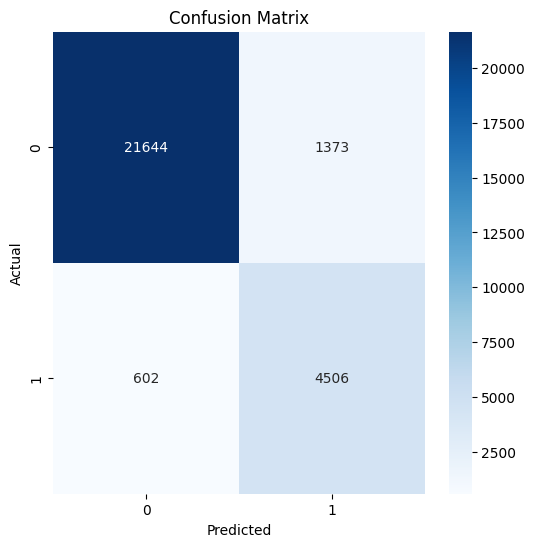

In [108]:
rf_model = RandomForestClassifier(**best_params_rf, random_state=42)
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

In [109]:
# Сравним показатели метрик моделей после подбора гиперпараметров
metrics_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,LogisticRegression,0.912142,0.692566,0.928348,0.793308,0.973078
1,RandomForestClassifier,0.934756,0.850954,0.776821,0.812199,0.970314
2,LGBMClassifier,0.917440,0.708595,0.926390,0.802987,0.973950
3,XGBClassifier,0.937742,0.837794,0.814996,0.826238,0.972666
4,XGBClassifier,0.937493,0.803993,0.867267,0.834432,0.974568
5,LGBMClassifier,0.925476,0.749090,0.886648,0.812085,0.970756
6,RandomForestClassifier,0.929778,0.766457,0.882146,0.820242,0.972141


Подбор гиперпараметров позволил улучшить качество всех моделей.

## **7.2. Создание ансамбля моделей**

In [119]:
# Создание ансамбля моделей
stacking_ensemble = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgb_model),
        ('rf', rf_model)
    ],
    final_estimator=LogisticRegression()
)

# Обучение модели
stacking_ensemble.fit(X_train, y_train)

# Прогнозирование
y_pred = stacking_ensemble.predict(X_test)
y_proba = stacking_ensemble.predict_proba(X_test)[:, 1]

# **8. Оценка модели**

## **8.1. Основные метрики**

In [122]:
# Посчитаем основные метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Вывод метрик
print(f"Метрики качества для модели {type(stacking_ensemble).__name__}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Метрики качества для модели StackingClassifier:
Accuracy: 0.9395
Precision: 0.8355
Recall: 0.8303
F1-Score: 0.8329
ROC-AUC: 0.9742


Ансамбль модели показал хорошие результаты.

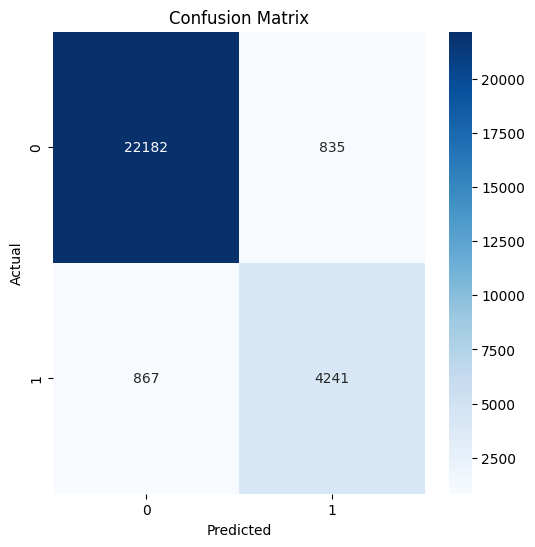

In [136]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **8.2. ROC-кривая**

Построим ROC-кривую.

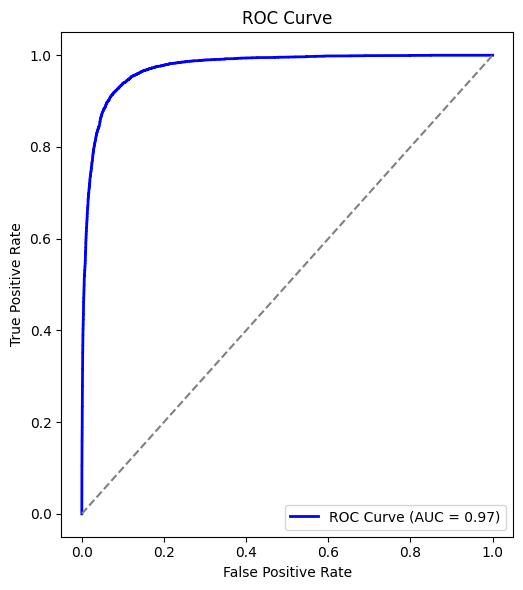

In [123]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)  # Вычисляем координаты для ROC кривой
roc_auc = auc(fpr, tpr)  # Вычисляем площадь под кривой

# Строим обе кривые
plt.figure(figsize=(10, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Показываем графики
plt.tight_layout()
plt.show()

Модель классифицирует очень хорошо, так как AUC = 0.97 → почти идеальный классификатор.

Ложных срабатываний мало (FPR ≈ 0 на начальном участке).

## **8.3. PR-кривая**

Построим PR кривую и найдем оптимальный threshold

Оптимальный порог по F1-score: 0.378
Precision при threshold=0.37818802175357097: 0.8082
Recall при threshold=0.37818802175357097: 0.8620
F1-score при threshold=0.37818802175357097: 0.8342


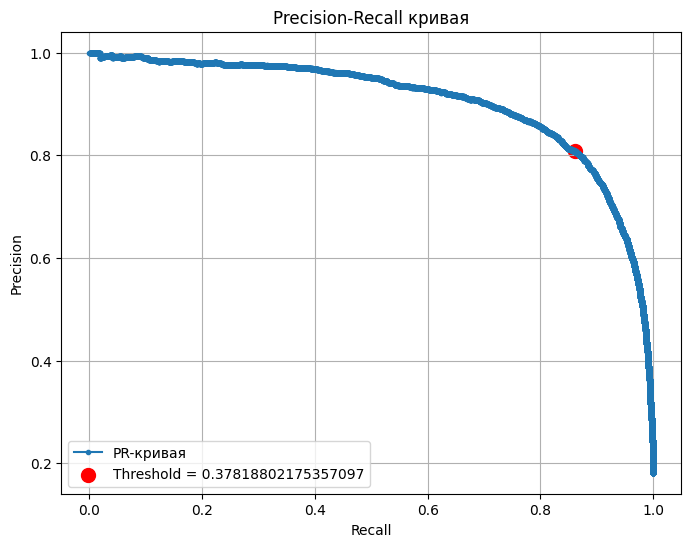

In [130]:
# Строим кривую precision-recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Выбираем порог, максимизирующий F1-score
best_threshold = thresholds[np.argmax(2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1]))]
print(f"Оптимальный порог по F1-score: {best_threshold:.3f}")

# 🔹 Вычисляем precision & recall для оптимального threshold
y_pred_adjusted = (y_proba >= best_threshold).astype(int)

precision_fixed = precision_score(y_test, y_pred_adjusted)
recall_fixed = recall_score(y_test, y_pred_adjusted)
f1_fixed = f1_score(y_test, y_pred_adjusted)

print(f"Precision при threshold={best_threshold}: {precision_fixed:.4f}")
print(f"Recall при threshold={best_threshold}: {recall_fixed:.4f}")
print(f"F1-score при threshold={best_threshold}: {f1_fixed:.4f}")

# 🔹 Визуализация PR-кривой
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label="PR-кривая")
plt.scatter(recall_fixed, precision_fixed, color="red", s=100, label=f"Threshold = {best_threshold}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall кривая")
plt.legend()
plt.grid()
plt.show()

В нашей задаче важно верно отслеживать риск депрессии, поэтому recall=0.8620 - это хороший результат.

## **8.4. Оценка важности признаков**

In [ ]:
# Вычисляем важность признаков с помощью Permutation Importance
result = permutation_importance(stacking_ensemble, X_test, y_test, scoring="f1")

                                      Feature  Importance
0                                         Age    0.331966
16  Have you ever had suicidal thoughts ?_Yes    0.113412
3                                    Pressure    0.074066
28                Profession_category_Student    0.062610
2                            Financial Stress    0.038887
4                                Satisfaction    0.020763
1                            Work/Study Hours    0.017219
10                   Dietary Habits_Unhealthy    0.011011
7            Sleep Duration_Less than 5 hours    0.002541
9                     Dietary Habits_Moderate    0.002085


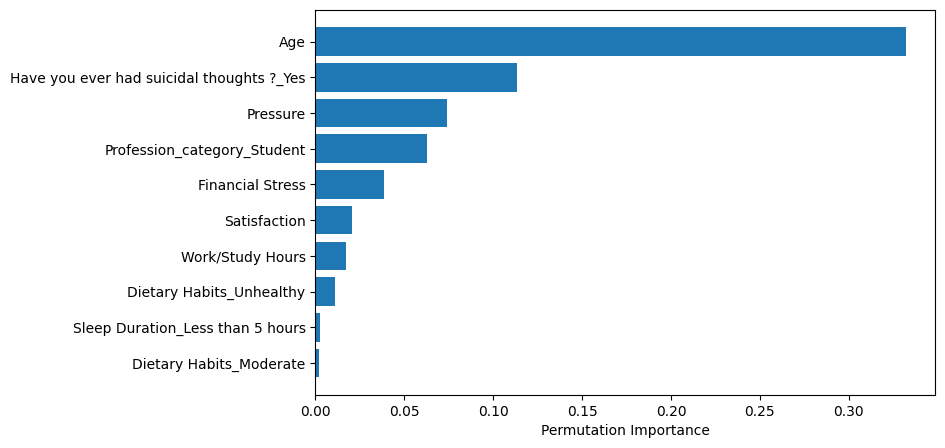

In [135]:
# Упаковываем в DataFrame
perm_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean
})

# Сортируем
perm_importance = perm_importance.sort_values("Importance", ascending=False)

# Выводим топ-10
print(perm_importance.head(10))

# Визуализируем
plt.figure(figsize=(8, 5))
plt.barh(perm_importance["Feature"][:10], perm_importance["Importance"][:10])
plt.xlabel("Permutation Importance")
plt.gca().invert_yaxis()
plt.show()

Анализ важности признаков подтвердил наши гипотезы.

Самый важный признак - **Age**.

На втором месте идет **Have you ever had suicidal thoughts ?_Yes**.

На третьем - **Pressure**

# **9. Выводы**



В рамках решения задачи бинарной классификации с целью своевременого выяывления риска депрессии было выполненно следующее:

1. Импортированы необходимые библиотеки и данные

2. Была осуществлена подготовка данных:

  * обработаны пропущенные значения;

  * проверены на наличие аномалий и выбросов;

  * сгруппированы некоторые признаки;

  * созданы новые признаки, в том числе с применением парсинга данных из интернета.

3. Осуществлен разведочный анализ данных:

  * посмотрели на распределение целевой переменной и признаков;

  * построили матрицу корреляции

4. Проведен препроцессинг с целью последующего обучения, а именно:

  * осущестлен выбор признаков с целью исключения мультиколлинеарности;

  * осуществлена кодировка категориальных признаков;

  * проведена нормализация данных;

5. Рассмотрены несколько вариантов моделей:

  * Логистическая регрессия (в качестве baseline);

  * Random Forest;

  * LightGBM;

  * XGBoost

6. Проведен подбор гиперпараметров с помощью optuna, реализован и обучен стеккинг моделей.

7. Осущестлена оценка обученной модели на тестовых данных, построены ROC- и PR-кривые, оценена важность признаков.


По результатам работы можно сделать следующие выводы:

1. Выявлены **ключевые факторы**, влияющие на уровень депрессии:

* **Возраст** играет значительную роль – более молодые участники имеют более высокий риск депрессии.

* Высокий уровень академического и рабочего **давления** связан с повышенной вероятностью депрессии.

* Финансовый **стресс** является одним из наиболее значимых факторов риска.

* **Недостаточная продолжительность сна** отрицательно сказывается на психическом здоровье.

2. В качестве финальной модели выбран **стэккинг** моделей Random Forest, LightGBM и XGBoost с подбором оптимальных гиперпараметров через optuna и LogisticRegression в качестве мета-модели.

3. Удалось добиться высоких значений метрик, например, recall финальной модели составляет **0.862**, а f1-score **0.8342**

